# QED Model Performance Analysis

This notebook analyzes the performance of different language models on QED (Question-Evidence-Deliberation) tasks. We examine three key aspects:

1. **Performance Trends**: Comparing zero_shot → first_only → second_only → both to see if adding examples helps models
2. **Static vs Random Examples**: Comparing static examples (first_only/second_only vs random_one, both vs random_two)
3. **Invalid Examples Analysis**: Analyzing invalid_number_of_examples trends by model and prompt type
4. **Prediction Quality Analysis**: Deep dive into prediction accuracy using ground truth annotations

All analyses focus on normalized metrics: all_mention, pair_alignment, and answer_accuracy.


In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Define paths and configurations
base_path = Path("../qed_model_results")
models = {
    "meta-llama/Meta-Llama-3-8B-Instruct": "LLaMA-3-8B",
    "Qwen/Qwen2.5-7B-Instruct": "Qwen2.5-7B",
    "models_fine_tuned/qwen2_5_7b_instruct_fewshot_random_two/checkpoint-1000": "Qwen2.5-7B-FT",
    "models_fine_tuned/llama3_8b_instruct_fewshot_random_two/checkpoint-954": "LLaMA-3-8B-FT"
}

prompt_types = [
    "zero_shot", "first_only", "second_only",
      "random_one", "both",  "random_two"
]

# Normalized metrics we care about
metrics_of_interest = [
    "all_mention_normalized", 
    "pair_alignment_normalized", 
    "answer_accuracy_normalized"
]

OVERLAP = 0.5

print(f"Models to analyze: {list(models.values())}")
print(f"Prompt types: {prompt_types}")
print(f"Metrics: {metrics_of_interest}")


Models to analyze: ['LLaMA-3-8B', 'Qwen2.5-7B', 'Qwen2.5-7B-FT', 'LLaMA-3-8B-FT']
Prompt types: ['zero_shot', 'first_only', 'second_only', 'random_one', 'both', 'random_two']
Metrics: ['all_mention_normalized', 'pair_alignment_normalized', 'answer_accuracy_normalized']


In [3]:
def load_model_results(base_path, models, prompt_types):
    """Load all model results from batch_evaluation_summary.json files"""
    results = []
    
    for model_path, model_name in models.items():
        model_dir = base_path / model_path
        
        for prompt_type in prompt_types:
            summary_file = model_dir / prompt_type / "batch_evaluation_summary.json"
            
            if summary_file.exists():
                try:
                    with open(summary_file, 'r') as f:
                        data = json.load(f)
                    
                    # Extract metrics from nested structure
                    # Use overlap_0.50_strict_False as the default threshold
                    overlap_key = f"overlap_{OVERLAP}0_strict_False"
                    
                    if overlap_key in data:
                        metrics_data = data[overlap_key]
                        normalized_metrics = metrics_data.get('metrics', {}).get('normalized', {})
                        
                        # Extract the F1 scores (middle value in the list for mention metrics)
                        all_mention = normalized_metrics.get('all_mention', [np.nan, np.nan, np.nan])
                        pair_alignment = normalized_metrics.get('pair', [np.nan, np.nan, np.nan])
                        answer_accuracy = normalized_metrics.get('answer_accuracy', np.nan)
                        
                        # Take the F1 score (middle value) for mention metrics
                        all_mention_f1 = all_mention[1] if len(all_mention) >= 2 else np.nan
                        pair_alignment_f1 = pair_alignment[1] if len(pair_alignment) >= 2 else np.nan
                        
                        result = {
                            'model': model_name,
                            'prompt_type': prompt_type,
                            'all_mention_normalized': all_mention_f1,
                            'pair_alignment_normalized': pair_alignment_f1,
                            'answer_accuracy_normalized': answer_accuracy,
                            'invalid_number_of_examples': metrics_data.get('invalid_number_of_examples', 0),
                            'model_type': 'fine_tuned' if 'FT' in model_name else 'base'

                        }
                    else:
                        print(f"⚠️  Unexpected structure in {model_name} - {prompt_type}")
                        raise Exception(f"Unexpected structure in {model_name} - {prompt_type}")
                    
                    results.append(result)
                    print(f"✓ Loaded {model_name} - {prompt_type}")
                    
                except Exception as e:
                    print(f"✗ Error loading {model_name} - {prompt_type}: {e}")
            else:
                print(f"✗ File not found: {summary_file}")
    
    return pd.DataFrame(results)

# Load all results
df_all = load_model_results(base_path, models, prompt_types)
print(f"\nLoaded {len(df_all)} results")
print(f"Shape: {df_all.shape}")

# Convert prompt_type column to categorical with your custom order
df_all['prompt_type'] = pd.Categorical(df_all['prompt_type'], categories=prompt_types, ordered=True)

# Now when you sort, it will use your custom order
df_all = df_all.sort_values('prompt_type')

df = df_all[df_all['model_type'] == 'base']
print("\nFirst few rows:")
df_all.head()


✓ Loaded LLaMA-3-8B - zero_shot
✓ Loaded LLaMA-3-8B - first_only
✓ Loaded LLaMA-3-8B - second_only
✓ Loaded LLaMA-3-8B - random_one
✓ Loaded LLaMA-3-8B - both
✓ Loaded LLaMA-3-8B - random_two
✓ Loaded Qwen2.5-7B - zero_shot
✓ Loaded Qwen2.5-7B - first_only
✓ Loaded Qwen2.5-7B - second_only
✓ Loaded Qwen2.5-7B - random_one
✓ Loaded Qwen2.5-7B - both
✓ Loaded Qwen2.5-7B - random_two
✓ Loaded Qwen2.5-7B-FT - zero_shot
✓ Loaded Qwen2.5-7B-FT - first_only
✓ Loaded Qwen2.5-7B-FT - second_only
✓ Loaded Qwen2.5-7B-FT - random_one
✓ Loaded Qwen2.5-7B-FT - both
✓ Loaded Qwen2.5-7B-FT - random_two
✓ Loaded LLaMA-3-8B-FT - zero_shot
✓ Loaded LLaMA-3-8B-FT - first_only
✓ Loaded LLaMA-3-8B-FT - second_only
✓ Loaded LLaMA-3-8B-FT - random_one
✓ Loaded LLaMA-3-8B-FT - both
✓ Loaded LLaMA-3-8B-FT - random_two

Loaded 24 results
Shape: (24, 7)

First few rows:


model prompt_type  all_mention_normalized  \
0      LLaMA-3-8B   zero_shot                0.053398   
12  Qwen2.5-7B-FT   zero_shot                0.017211   
18  LLaMA-3-8B-FT   zero_shot                0.268314   
6      Qwen2.5-7B   zero_shot                0.120918   
13  Qwen2.5-7B-FT  first_only                0.114298   

    pair_alignment_normalized  answer_accuracy_normalized  \
0                    0.017652                    0.815867   
12                   0.008826                    0.964740   
18                   0.152692                    0.815867   
6                    0.061783                    0.834476   
13                   0.075022                    0.899119   

    invalid_number_of_examples  model_type  
0                            1        base  
12                          12  fine_tuned  
18                           2  fine_tuned  
6                            8        base  
13                          28  fine_tuned

## 1. Performance Trends Analysis (Base Models)

Analyzing how performance changes as we add examples: zero_shot → first_only → second_only → both


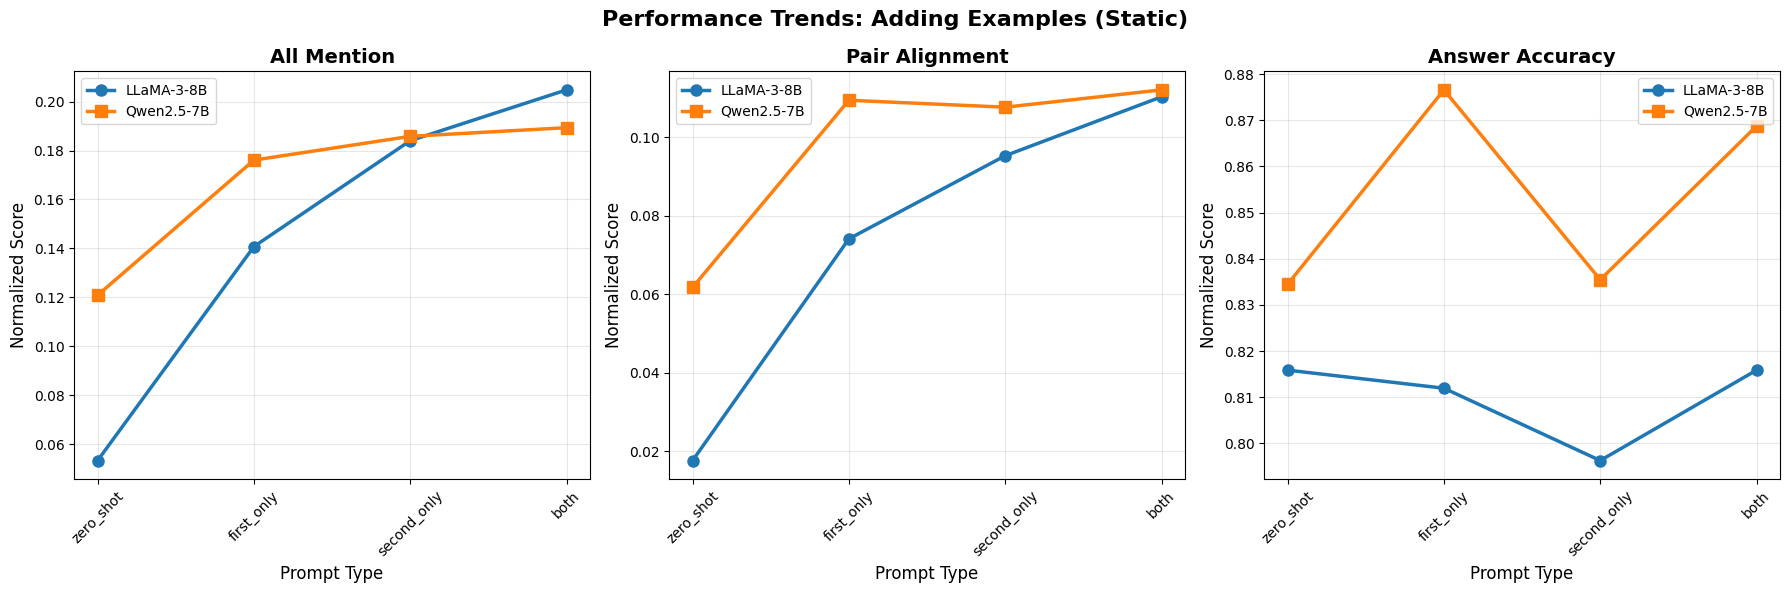

Performance Improvement Analysis:

LLaMA-3-8B:

  all_mention_normalized:
    zero_shot → first_only: 0.053 → 0.141 (+0.087)
    zero_shot → second_only: 0.053 → 0.184 (+0.131)
    zero_shot → both: 0.053 → 0.205 (+0.151)
    Best improvement: +0.151

  pair_alignment_normalized:
    zero_shot → first_only: 0.018 → 0.074 (+0.056)
    zero_shot → second_only: 0.018 → 0.095 (+0.078)
    zero_shot → both: 0.018 → 0.110 (+0.093)
    Best improvement: +0.093

  answer_accuracy_normalized:
    zero_shot → first_only: 0.816 → 0.812 (-0.004)
    zero_shot → second_only: 0.816 → 0.796 (-0.020)
    zero_shot → both: 0.816 → 0.816 (+0.000)
    Best improvement: +0.000

Qwen2.5-7B:

  all_mention_normalized:
    zero_shot → first_only: 0.121 → 0.176 (+0.055)
    zero_shot → second_only: 0.121 → 0.186 (+0.065)
    zero_shot → both: 0.121 → 0.189 (+0.068)
    Best improvement: +0.068

  pair_alignment_normalized:
    zero_shot → first_only: 0.062 → 0.109 (+0.048)
    zero_shot → second_only: 0.062 →

In [4]:
# Filter for static prompt types (trend analysis)
static_prompts = ["zero_shot", "first_only", "second_only", "both"]
df_static = df[df['prompt_type'].isin(static_prompts)].copy()

# Create trend plots - both models on same plots for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Performance Trends: Adding Examples (Static)', fontsize=16, fontweight='bold')

metric_names = {
    'all_mention_normalized': 'All Mention',
    'pair_alignment_normalized': 'Pair Alignment', 
    'answer_accuracy_normalized': 'Answer Accuracy'
}

colors = {'LLaMA-3-8B': '#1f77b4', 'Qwen2.5-7B': '#ff7f0e'}
markers = {'LLaMA-3-8B': 'o', 'Qwen2.5-7B': 's'}

for idx, (metric, title) in enumerate(metric_names.items()):
    ax = axes[idx]
    
    for model in df_static['model'].unique():
        model_data = df_static[df_static['model'] == model]
        
        # Sort by prompt order for trend
        prompt_order = ["zero_shot", "first_only", "second_only", "both"]
        model_data = model_data.set_index('prompt_type').reindex(prompt_order).reset_index()
        
        ax.plot(model_data['prompt_type'], model_data[metric], 
                marker=markers[model], linewidth=2.5, markersize=8,
                label=model, color=colors[model])
    
    ax.set_title(f'{title}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Prompt Type', fontsize=12)
    ax.set_ylabel('Normalized Score', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Numerical analysis
print("Performance Improvement Analysis:")
print("="*50)

for model in df_static['model'].unique():
    print(f"\n{model}:")
    model_data = df_static[df_static['model'] == model]
    
    for metric in metrics_of_interest:
        print(f"\n  {metric}:")
        
        # Get values for each prompt type
        zero_shot = model_data[model_data['prompt_type'] == 'zero_shot'][metric].iloc[0]
        first_only = model_data[model_data['prompt_type'] == 'first_only'][metric].iloc[0]
        second_only = model_data[model_data['prompt_type'] == 'second_only'][metric].iloc[0]
        both = model_data[model_data['prompt_type'] == 'both'][metric].iloc[0]
        
        print(f"    zero_shot → first_only: {zero_shot:.3f} → {first_only:.3f} ({first_only-zero_shot:+.3f})")
        print(f"    zero_shot → second_only: {zero_shot:.3f} → {second_only:.3f} ({second_only-zero_shot:+.3f})")
        print(f"    zero_shot → both: {zero_shot:.3f} → {both:.3f} ({both-zero_shot:+.3f})")
        print(f"    Best improvement: {max(first_only-zero_shot, second_only-zero_shot, both-zero_shot):+.3f}")


## 2. Static vs Random Examples Comparison

Comparing static examples vs randomly selected examples to see if the specific choice of examples matters (only base models).


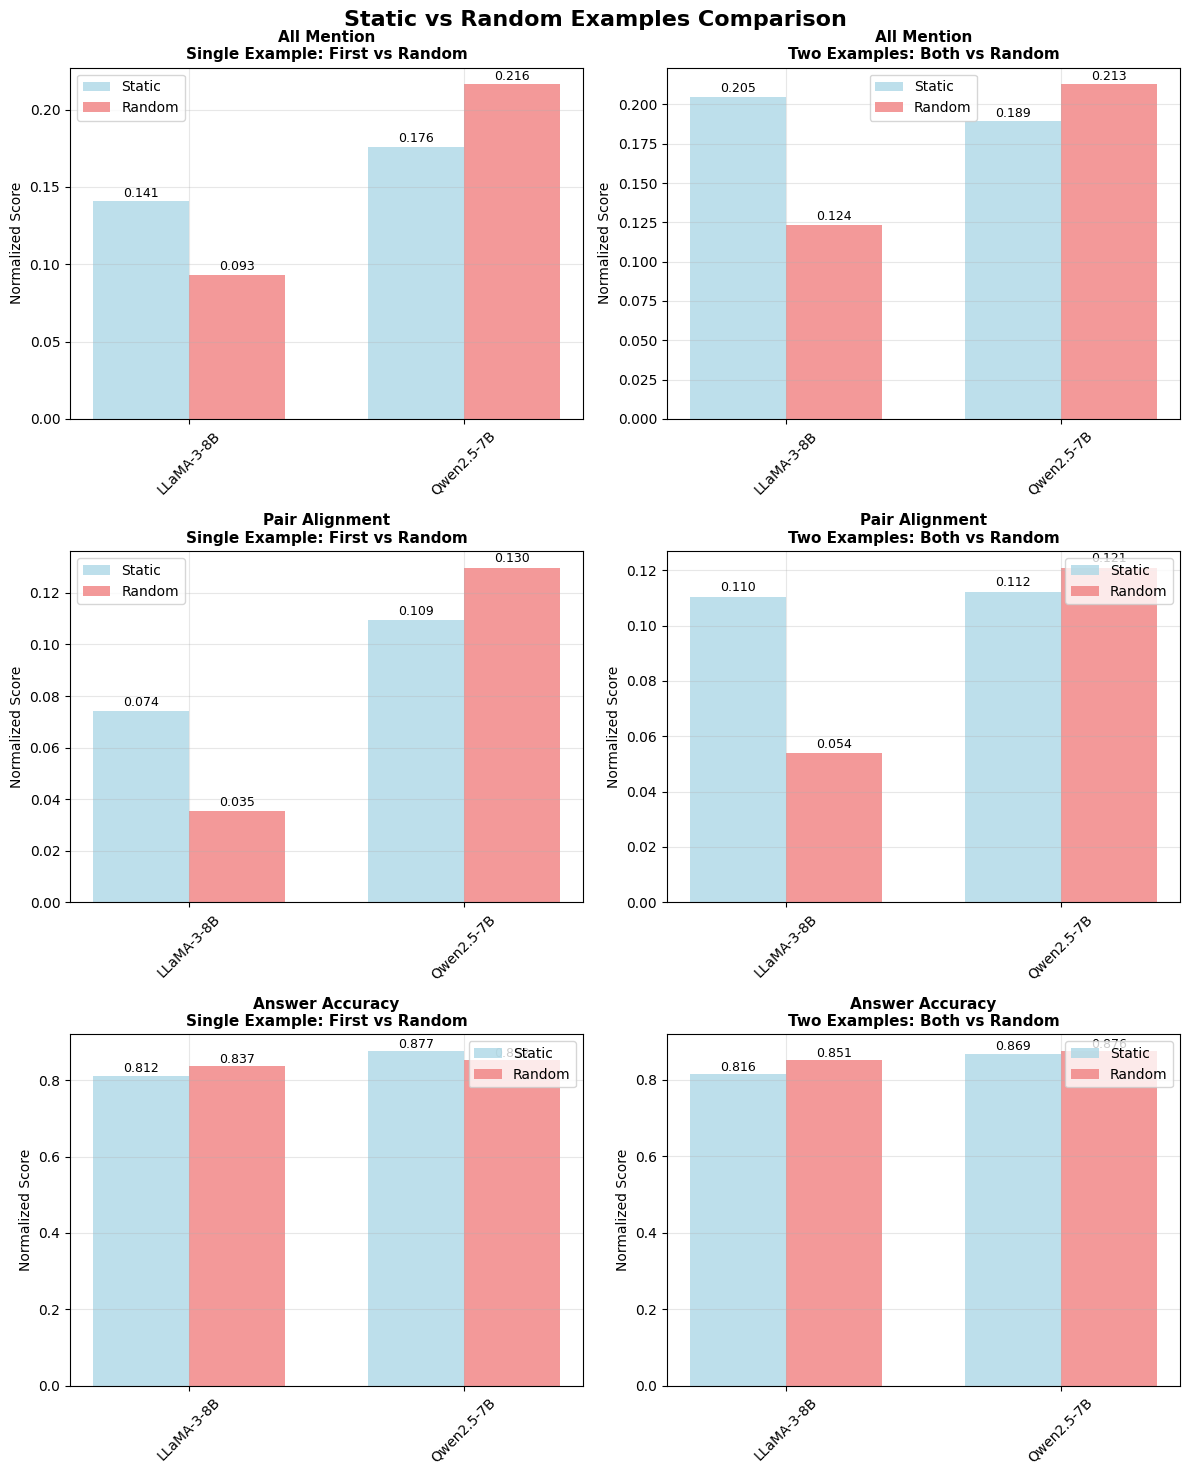

Static vs Random Numerical Comparison:

Single Example: First vs Random:
-------------------------------

LLaMA-3-8B:
  all_mention_normalized: Static=0.141, Random=0.093, Diff=+0.048 (Static better)
  pair_alignment_normalized: Static=0.074, Random=0.035, Diff=+0.039 (Static better)
  answer_accuracy_normalized: Static=0.812, Random=0.837, Diff=-0.025 (Random better)

Qwen2.5-7B:
  all_mention_normalized: Static=0.176, Random=0.216, Diff=-0.040 (Random better)
  pair_alignment_normalized: Static=0.109, Random=0.130, Diff=-0.020 (Random better)
  answer_accuracy_normalized: Static=0.877, Random=0.852, Diff=+0.024 (Static better)

Two Examples: Both vs Random:
----------------------------

LLaMA-3-8B:
  all_mention_normalized: Static=0.205, Random=0.124, Diff=+0.081 (Static better)
  pair_alignment_normalized: Static=0.110, Random=0.054, Diff=+0.056 (Static better)
  answer_accuracy_normalized: Static=0.816, Random=0.851, Diff=-0.035 (Random better)

Qwen2.5-7B:
  all_mention_normalized

In [5]:
# Static vs Random Comparison using bar plots
comparison_data = []

# Define the specific comparisons we want
all_comparisons = [
    ('first_only', 'random_one', 'Single Example: First vs Random'),
    ('both', 'random_two', 'Two Examples: Both vs Random')
]

# Prepare data for plotting
for static_prompt, random_prompt, comparison_name in all_comparisons:
    for model in df['model'].unique():
        for metric in metrics_of_interest:
            static_value = df[(df['model'] == model) & (df['prompt_type'] == static_prompt)][metric].iloc[0]
            random_value = df[(df['model'] == model) & (df['prompt_type'] == random_prompt)][metric].iloc[0]
            
            comparison_data.extend([
                {
                    'model': model,
                    'metric': metric,
                    'comparison': comparison_name,
                    'type': 'Static',
                    'value': static_value,
                    'prompt_pair': f"{static_prompt} vs {random_prompt}"
                },
                {
                    'model': model, 
                    'metric': metric,
                    'comparison': comparison_name,
                    'type': 'Random',
                    'value': random_value,
                    'prompt_pair': f"{static_prompt} vs {random_prompt}"
                }
            ])

comparison_df = pd.DataFrame(comparison_data)

# Create bar plots - now 3x2 since we have 2 comparisons instead of 3
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle('Static vs Random Examples Comparison', fontsize=16, fontweight='bold')

metric_names = {
    'all_mention_normalized': 'All Mention',
    'pair_alignment_normalized': 'Pair Alignment', 
    'answer_accuracy_normalized': 'Answer Accuracy'
}

for metric_idx, (metric, metric_name) in enumerate(metric_names.items()):
    for comp_idx, (static_prompt, random_prompt, comparison_name) in enumerate(all_comparisons):
        ax = axes[metric_idx, comp_idx]
        
        # Filter data for this metric and comparison
        plot_data = comparison_df[
            (comparison_df['metric'] == metric) & 
            (comparison_df['comparison'] == comparison_name)
        ]
        
        # Create grouped bar plot
        x_pos = np.arange(len(plot_data['model'].unique()))
        width = 0.35
        
        static_values = []
        random_values = []
        
        for model in sorted(plot_data['model'].unique()):
            static_val = plot_data[(plot_data['model'] == model) & (plot_data['type'] == 'Static')]['value'].iloc[0]
            random_val = plot_data[(plot_data['model'] == model) & (plot_data['type'] == 'Random')]['value'].iloc[0]
            static_values.append(static_val)
            random_values.append(random_val)
        
        bars1 = ax.bar(x_pos - width/2, static_values, width, label='Static', alpha=0.8, color='lightblue')
        bars2 = ax.bar(x_pos + width/2, random_values, width, label='Random', alpha=0.8, color='lightcoral')
        
        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)
                   
        for bar in bars2:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)
        
        ax.set_title(f'{metric_name}\n{comparison_name}', fontsize=11, fontweight='bold')
        ax.set_ylabel('Normalized Score', fontsize=10)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(sorted(plot_data['model'].unique()), rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Numerical comparison
print("Static vs Random Numerical Comparison:")
print("="*50)

for static_prompt, random_prompt, comparison_name in all_comparisons:
    print(f"\n{comparison_name}:")
    print("-" * len(comparison_name))
    
    for model in df['model'].unique():
        print(f"\n{model}:")
        
        for metric in metrics_of_interest:
            static_value = df[(df['model'] == model) & (df['prompt_type'] == static_prompt)][metric].iloc[0]
            random_value = df[(df['model'] == model) & (df['prompt_type'] == random_prompt)][metric].iloc[0]
            difference = static_value - random_value
            
            better = "Static" if difference > 0 else "Random"
            print(f"  {metric}: Static={static_value:.3f}, Random={random_value:.3f}, Diff={difference:+.3f} ({better} better)")


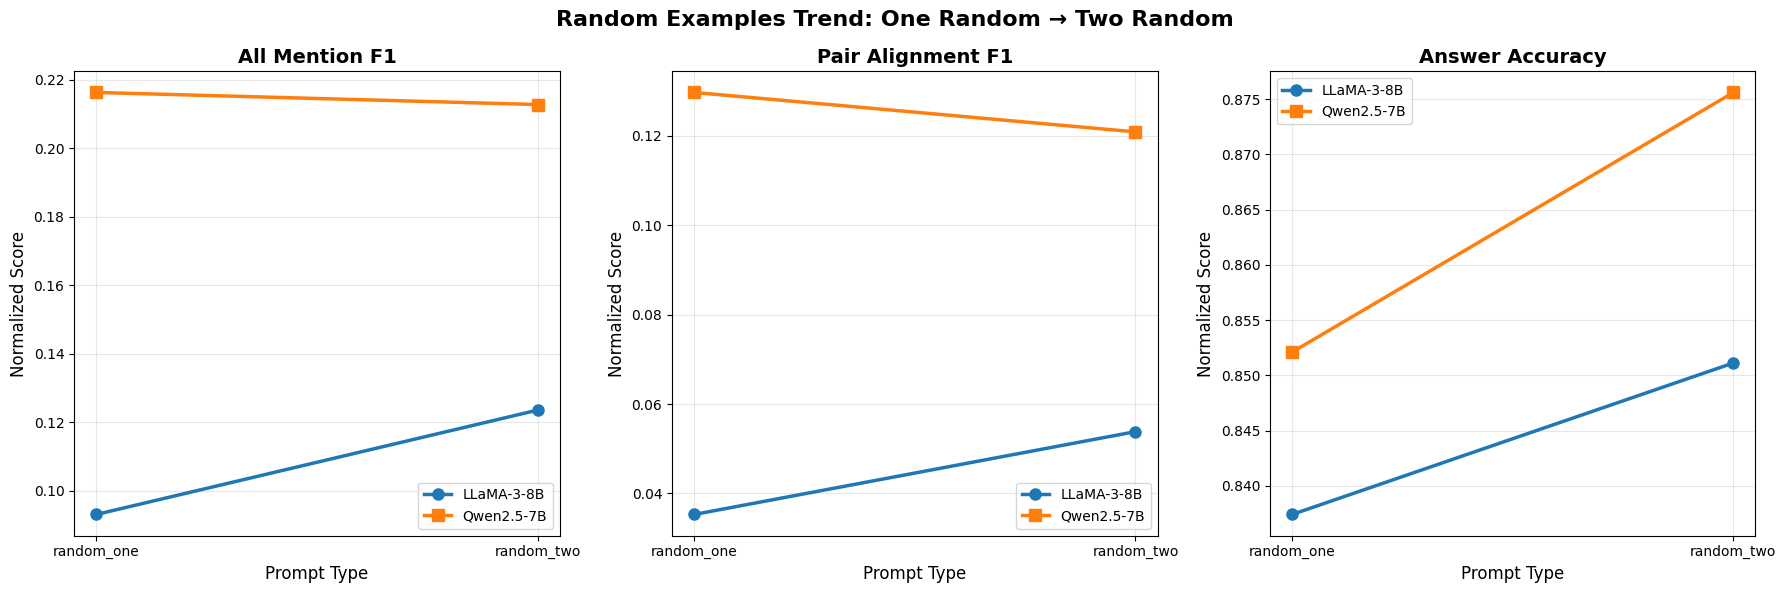

Random Examples Trend Analysis:

LLaMA-3-8B:

  all_mention_normalized:
    random_one → random_two: 0.093 → 0.124 (+0.030)
    ✓ Adding second random example helps (+0.030)

  pair_alignment_normalized:
    random_one → random_two: 0.035 → 0.054 (+0.019)
    ✓ Adding second random example helps (+0.019)

  answer_accuracy_normalized:
    random_one → random_two: 0.837 → 0.851 (+0.014)
    ✓ Adding second random example helps (+0.014)

Qwen2.5-7B:

  all_mention_normalized:
    random_one → random_two: 0.216 → 0.213 (-0.004)
    ✗ Adding second random example hurts (-0.004)

  pair_alignment_normalized:
    random_one → random_two: 0.130 → 0.121 (-0.009)
    ✗ Adding second random example hurts (-0.009)

  answer_accuracy_normalized:
    random_one → random_two: 0.852 → 0.876 (+0.024)
    ✓ Adding second random example helps (+0.024)


In [ ]:
# Random trend analysis: random_one → random_two
random_prompts = ["random_one", "random_two"]
df_random = df[df['prompt_type'].isin(random_prompts)].copy()

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Random Examples Trend: One Random → Two Random', fontsize=16, fontweight='bold')

for idx, (metric, title) in enumerate(metric_names.items()):
    ax = axes[idx]
    
    for model in df_random['model'].unique():
        model_data = df_random[df_random['model'] == model]
        
        # Sort by prompt order
        prompt_order = ["random_one", "random_two"]
        model_data = model_data.set_index('prompt_type').reindex(prompt_order).reset_index()
        
        ax.plot(model_data['prompt_type'], model_data[metric], 
                marker=markers[model], linewidth=2.5, markersize=8,
                label=model, color=colors[model])
    
    ax.set_title(f'{title}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Prompt Type', fontsize=12)
    ax.set_ylabel('Normalized Score', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

# Numerical analysis for random trend
print("Random Examples Trend Analysis:")
print("="*40)

for model in df_random['model'].unique():
    print(f"\n{model}:")
    model_data = df_random[df_random['model'] == model]
    
    for metric in metrics_of_interest:
        print(f"\n  {metric}:")
        
        random_one = model_data[model_data['prompt_type'] == 'random_one'][metric].iloc[0]
        random_two = model_data[model_data['prompt_type'] == 'random_two'][metric].iloc[0]
        
        improvement = random_two - random_one
        print(f"    random_one → random_two: {random_one:.3f} → {random_two:.3f} ({improvement:+.3f})")
        
        if improvement > 0:
            print(f"    ✓ Adding second random example helps (+{improvement:.3f})")
        else:
            print(f"    ✗ Adding second random example hurts ({improvement:.3f})")


## 4. Fine-tuned vs Base Model Performance Analysis


This section compares the performance of fine-tuned models against their base counterparts, and also compares fine-tuned models against each other. We analyze:

1. **Fine-tuned Qwen vs Fine-tuned Llama** on each prompt type
2. **Fine-tuned vs Base model** performance (separately for Qwen and Llama) on each prompt type
3. Individual plots for each performance metric
4. Combined plot showing all metrics with separate trend lines

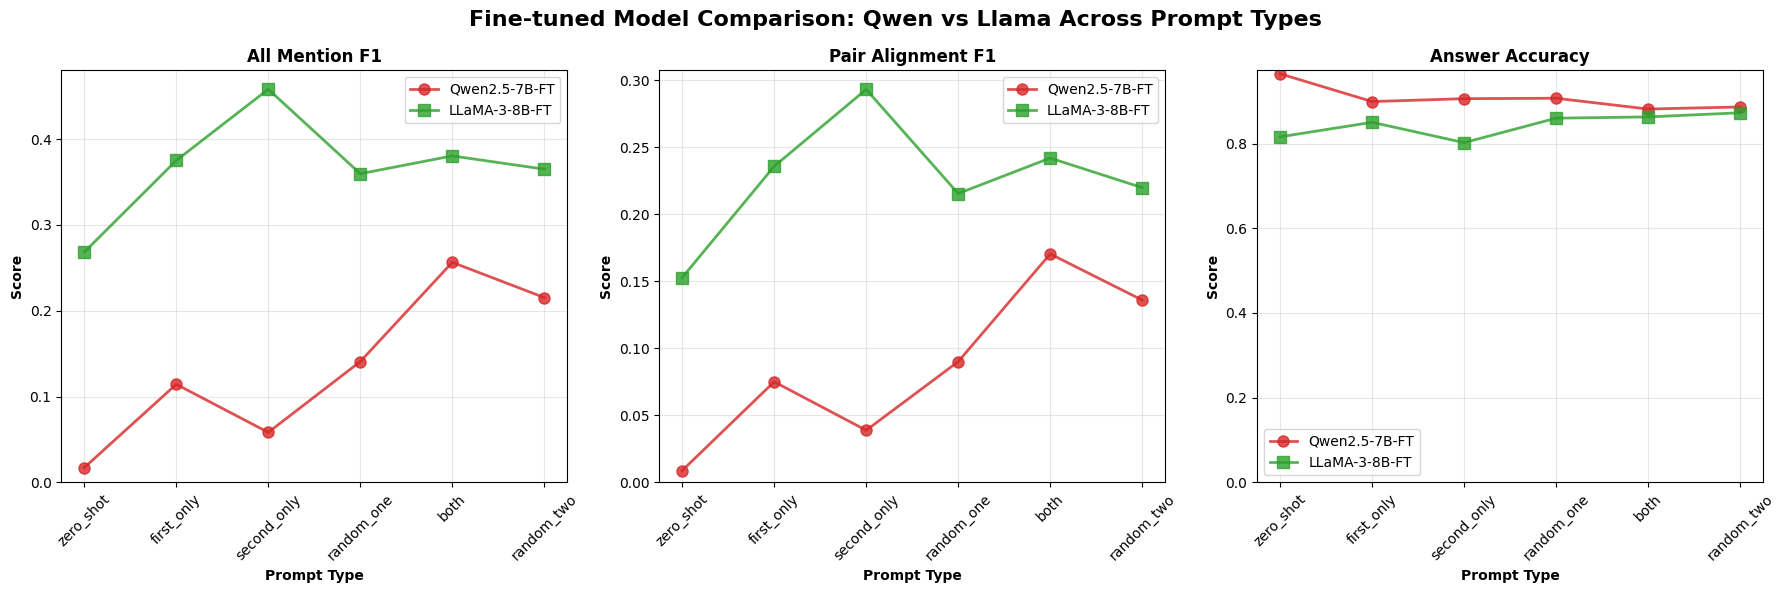

Fine-tuned Model Performance Comparison:

All Mention F1:
------------------------------
  zero_shot: Qwen=0.017, Llama=0.268 → Llama wins by 0.251
  first_only: Qwen=0.114, Llama=0.375 → Llama wins by 0.261
  second_only: Qwen=0.058, Llama=0.458 → Llama wins by 0.400
  random_one: Qwen=0.141, Llama=0.360 → Llama wins by 0.219
  both: Qwen=0.256, Llama=0.380 → Llama wins by 0.124
  random_two: Qwen=0.215, Llama=0.365 → Llama wins by 0.150

Pair Alignment F1:
------------------------------
  zero_shot: Qwen=0.009, Llama=0.153 → Llama wins by 0.144
  first_only: Qwen=0.075, Llama=0.236 → Llama wins by 0.161
  second_only: Qwen=0.039, Llama=0.293 → Llama wins by 0.254
  random_one: Qwen=0.090, Llama=0.215 → Llama wins by 0.125
  both: Qwen=0.170, Llama=0.242 → Llama wins by 0.071
  random_two: Qwen=0.136, Llama=0.220 → Llama wins by 0.084

Answer Accuracy:
------------------------------
  zero_shot: Qwen=0.965, Llama=0.816 → Qwen wins by 0.149
  first_only: Qwen=0.899, Llama=0.850 → Qwen 

In [6]:
# Fine-tuned model comparison: Qwen vs Llama
df_ft_only = df_all[df_all['model_type'] == 'fine_tuned'].copy()

# Create individual plots for each metric comparing fine-tuned models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Fine-tuned Model Comparison: Qwen vs Llama Across Prompt Types', fontsize=16, fontweight='bold')

metric_names = {
    'all_mention_normalized': 'All Mention F1',
    'pair_alignment_normalized': 'Pair Alignment F1', 
    'answer_accuracy_normalized': 'Answer Accuracy'
}

colors_ft = {'Qwen2.5-7B-FT': '#d62728', 'LLaMA-3-8B-FT': '#2ca02c'}
markers_ft = {'Qwen2.5-7B-FT': 'o', 'LLaMA-3-8B-FT': 's'}

for idx, (metric, title) in enumerate(metric_names.items()):
    ax = axes[idx]
    
    for model in df_ft_only['model'].unique():
        model_data = df_ft_only[df_ft_only['model'] == model]
        
        ax.plot(model_data['prompt_type'], model_data[metric], 
                marker=markers_ft[model], color=colors_ft[model], 
                linewidth=2, markersize=8, label=model, alpha=0.8)
    
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_xlabel('Prompt Type', fontweight='bold')
    ax.set_ylabel('Score', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Set y-axis to start from 0 for better comparison
    ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Print numerical comparison
print("Fine-tuned Model Performance Comparison:")
print("="*50)
for metric in metrics_of_interest:
    print(f"\n{metric_names[metric]}:")
    print("-" * 30)
    for prompt_type in prompt_types:
        qwen_score = df_ft_only[(df_ft_only['model'] == 'Qwen2.5-7B-FT') & 
                                (df_ft_only['prompt_type'] == prompt_type)][metric].values
        llama_score = df_ft_only[(df_ft_only['model'] == 'LLaMA-3-8B-FT') & 
                                 (df_ft_only['prompt_type'] == prompt_type)][metric].values
        
        qwen_val = qwen_score[0] if len(qwen_score) > 0 else np.nan
        llama_val = llama_score[0] if len(llama_score) > 0 else np.nan
        
        if not np.isnan(qwen_val) and not np.isnan(llama_val):
            winner = "Qwen" if qwen_val > llama_val else "Llama"
            diff = abs(qwen_val - llama_val)
            print(f"  {prompt_type}: Qwen={qwen_val:.3f}, Llama={llama_val:.3f} → {winner} wins by {diff:.3f}")
        else:
            print(f"  {prompt_type}: Qwen={qwen_val:.3f}, Llama={llama_val:.3f}")


### 4.2 Fine-tuned vs Base Model Comparison

Comparing the performance improvement of fine-tuning for each model family (Qwen and Llama) across all prompt types.


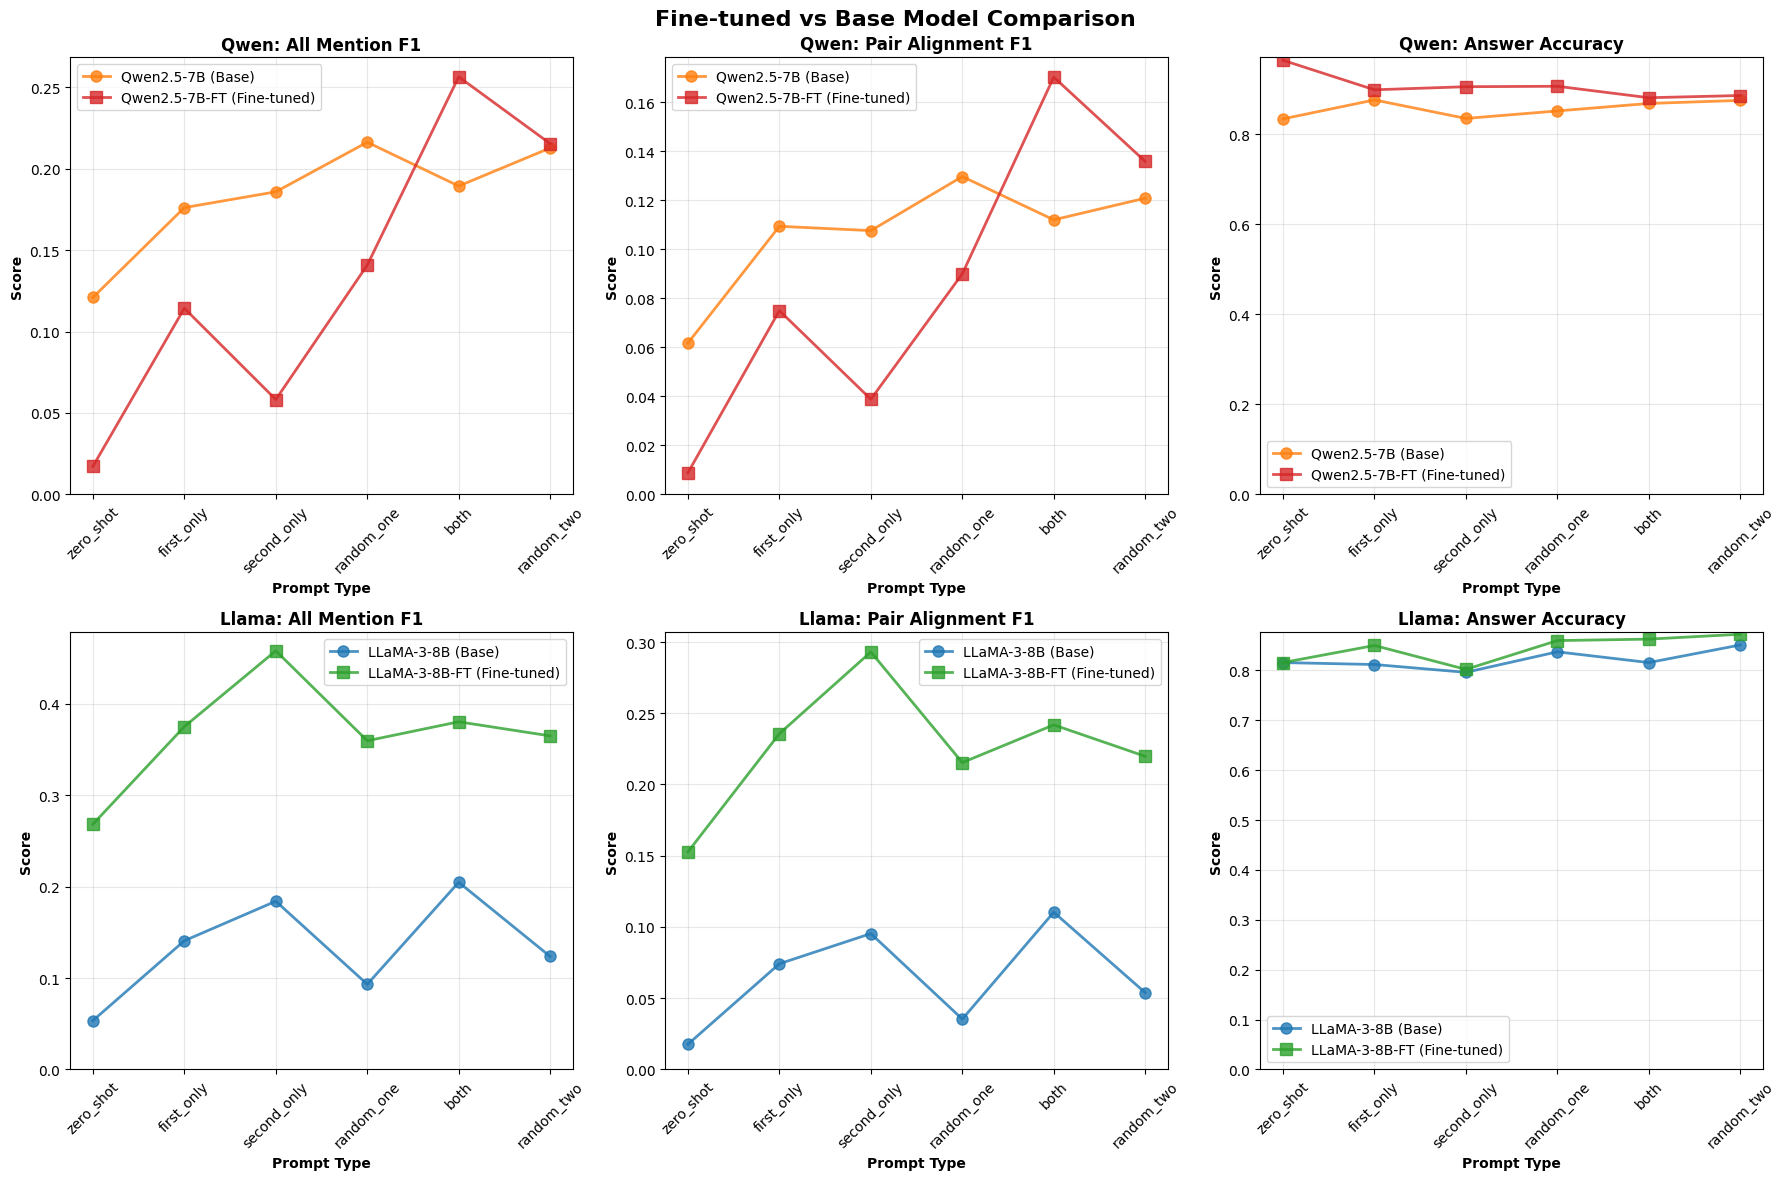

Fine-tuning Performance Improvements:

Qwen Model Family:
------------------------------

  All Mention F1:
    zero_shot: 0.121 → 0.017 (-0.104, -85.8%) ↓
    first_only: 0.176 → 0.114 (-0.062, -35.1%) ↓
    second_only: 0.186 → 0.058 (-0.128, -68.6%) ↓
    random_one: 0.216 → 0.141 (-0.075, -34.9%) ↓
    both: 0.189 → 0.256 (+0.067, +35.4%) ↑
    random_two: 0.213 → 0.215 (+0.003, +1.2%) ↑
    Average improvement: -0.050

  Pair Alignment F1:
    zero_shot: 0.062 → 0.009 (-0.053, -85.7%) ↓
    first_only: 0.109 → 0.075 (-0.034, -31.5%) ↓
    second_only: 0.108 → 0.039 (-0.069, -63.9%) ↓
    random_one: 0.130 → 0.090 (-0.040, -30.6%) ↓
    both: 0.112 → 0.170 (+0.058, +52.0%) ↑
    random_two: 0.121 → 0.136 (+0.015, +12.4%) ↑
    Average improvement: -0.020

  Answer Accuracy:
    zero_shot: 0.834 → 0.965 (+0.130, +15.6%) ↑
    first_only: 0.877 → 0.899 (+0.023, +2.6%) ↑
    second_only: 0.835 → 0.906 (+0.071, +8.4%) ↑
    random_one: 0.852 → 0.907 (+0.055, +6.4%) ↑
    both: 0.869 → 

In [7]:
# Fine-tuned vs Base model comparison
# Create separate plots for Qwen and Llama families

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Fine-tuned vs Base Model Comparison', fontsize=16, fontweight='bold')

# Model family mappings
model_families = {
    'Qwen': {
        'base': 'Qwen2.5-7B',
        'fine_tuned': 'Qwen2.5-7B-FT',
        'colors': {'base': '#ff7f0e', 'fine_tuned': '#d62728'},
        'markers': {'base': 'o', 'fine_tuned': 's'}
    },
    'Llama': {
        'base': 'LLaMA-3-8B',
        'fine_tuned': 'LLaMA-3-8B-FT',
        'colors': {'base': '#1f77b4', 'fine_tuned': '#2ca02c'},
        'markers': {'base': 'o', 'fine_tuned': 's'}
    }
}

for family_idx, (family_name, family_config) in enumerate(model_families.items()):
    for metric_idx, (metric, title) in enumerate(metric_names.items()):
        ax = axes[family_idx, metric_idx]
        
        # Plot base model
        base_data = df_all[(df_all['model'] == family_config['base']) & 
                          (df_all['model_type'] == 'base')]
        
        if not base_data.empty:
            ax.plot(base_data['prompt_type'], base_data[metric], 
                    marker=family_config['markers']['base'], 
                    color=family_config['colors']['base'], 
                    linewidth=2, markersize=8, 
                    label=f'{family_config["base"]} (Base)', alpha=0.8)
        
        # Plot fine-tuned model
        ft_data = df_all[(df_all['model'] == family_config['fine_tuned']) & 
                        (df_all['model_type'] == 'fine_tuned')]
        
        if not ft_data.empty:
            ax.plot(ft_data['prompt_type'], ft_data[metric], 
                    marker=family_config['markers']['fine_tuned'], 
                    color=family_config['colors']['fine_tuned'], 
                    linewidth=2, markersize=8, 
                    label=f'{family_config["fine_tuned"]} (Fine-tuned)', alpha=0.8)
        
        ax.set_title(f'{family_name}: {title}', fontweight='bold', fontsize=12)
        ax.set_xlabel('Prompt Type', fontweight='bold')
        ax.set_ylabel('Score', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Calculate and print improvement metrics
print("Fine-tuning Performance Improvements:")
print("="*50)

for family_name, family_config in model_families.items():
    print(f"\n{family_name} Model Family:")
    print("-" * 30)
    
    for metric in metrics_of_interest:
        print(f"\n  {metric_names[metric]}:")
        improvements = []
        
        for prompt_type in prompt_types:
            base_score = df_all[(df_all['model'] == family_config['base']) & 
                               (df_all['model_type'] == 'base') &
                               (df_all['prompt_type'] == prompt_type)][metric].values
            ft_score = df_all[(df_all['model'] == family_config['fine_tuned']) & 
                             (df_all['model_type'] == 'fine_tuned') &
                             (df_all['prompt_type'] == prompt_type)][metric].values
            
            base_val = base_score[0] if len(base_score) > 0 else np.nan
            ft_val = ft_score[0] if len(ft_score) > 0 else np.nan
            
            if not np.isnan(base_val) and not np.isnan(ft_val):
                improvement = ft_val - base_val
                improvement_pct = (improvement / base_val) * 100 if base_val != 0 else 0
                improvements.append(improvement)
                
                status = "↑" if improvement > 0 else "↓" if improvement < 0 else "="
                print(f"    {prompt_type}: {base_val:.3f} → {ft_val:.3f} ({improvement:+.3f}, {improvement_pct:+.1f}%) {status}")
            else:
                print(f"    {prompt_type}: {base_val:.3f} → {ft_val:.3f} (data missing)")
        
        if improvements:
            avg_improvement = np.mean(improvements)
            print(f"    Average improvement: {avg_improvement:+.3f}")


### 4.3 Combined Metric Analysis

Combined visualization showing all performance metrics with separate trend lines for each metric across all models.


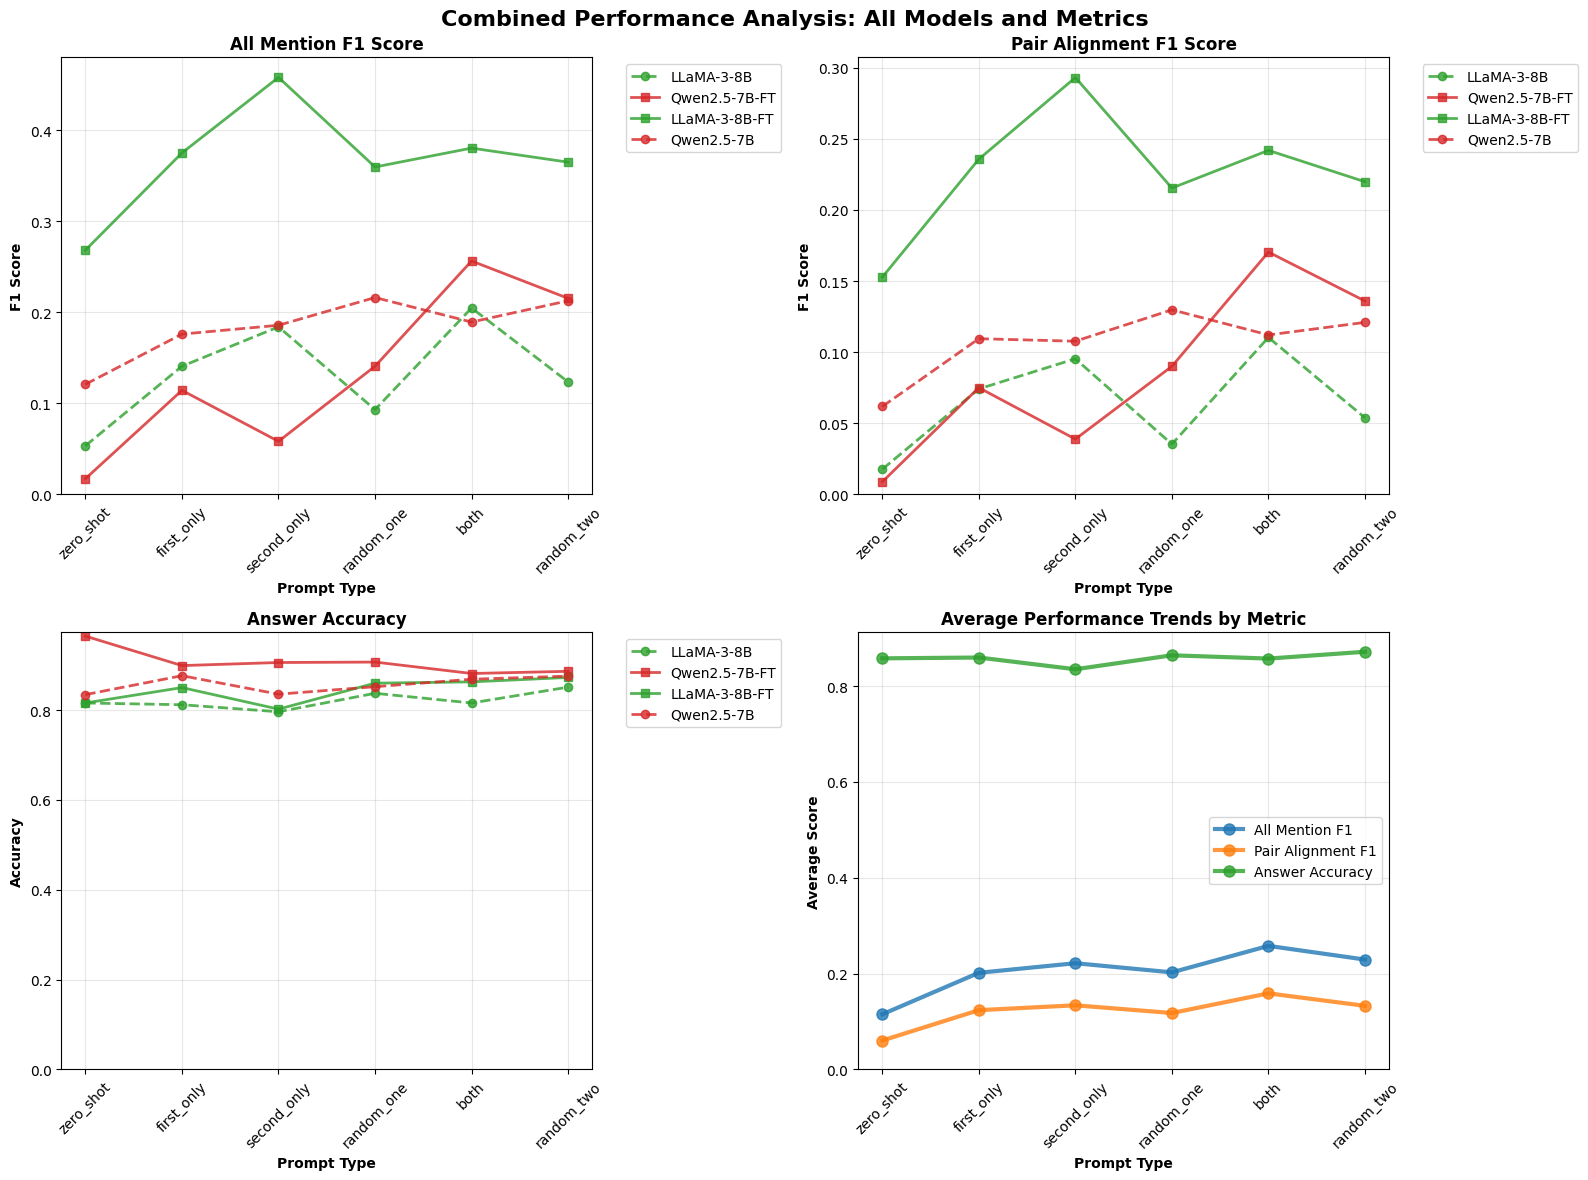

Summary Statistics:

Best performing model per metric (across all prompt types):

All Mention F1:
  1. LLaMA-3-8B-FT (FT): 0.368
  2. Qwen2.5-7B (Base): 0.184
  3. Qwen2.5-7B-FT (FT): 0.134
  4. LLaMA-3-8B (Base): 0.133

Pair Alignment F1:
  1. LLaMA-3-8B-FT (FT): 0.226
  2. Qwen2.5-7B (Base): 0.107
  3. Qwen2.5-7B-FT (FT): 0.086
  4. LLaMA-3-8B (Base): 0.064

Answer Accuracy:
  1. Qwen2.5-7B-FT (FT): 0.907
  2. Qwen2.5-7B (Base): 0.857
  3. LLaMA-3-8B-FT (FT): 0.844
  4. LLaMA-3-8B (Base): 0.821

Best performing prompt type per metric (average across all models):

All Mention F1:
  1. both: 0.258
  2. random_two: 0.229
  3. second_only: 0.222

Pair Alignment F1:
  1. both: 0.159
  2. second_only: 0.134
  3. random_two: 0.133

Answer Accuracy:
  1. random_two: 0.871
  2. random_one: 0.864
  3. first_only: 0.859


In [8]:
# Combined metric analysis with all models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Combined Performance Analysis: All Models and Metrics', fontsize=16, fontweight='bold')

# Plot 1: All models with All Mention metric
ax1 = axes[0, 0]
for model in df_all['model'].unique():
    model_data = df_all[df_all['model'] == model]
    model_type = model_data['model_type'].iloc[0]
    
    color = '#d62728' if 'Qwen' in model else '#2ca02c' if 'LLaMA' in model else '#1f77b4'
    marker = 's' if 'FT' in model else 'o'
    linestyle = '-' if model_type == 'fine_tuned' else '--'
    
    ax1.plot(model_data['prompt_type'], model_data['all_mention_normalized'], 
             marker=marker, color=color, linewidth=2, markersize=6, 
             label=model, alpha=0.8, linestyle=linestyle)

ax1.set_title('All Mention F1 Score', fontweight='bold', fontsize=12)
ax1.set_xlabel('Prompt Type', fontweight='bold')
ax1.set_ylabel('F1 Score', fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(bottom=0)

# Plot 2: All models with Pair Alignment metric
ax2 = axes[0, 1]
for model in df_all['model'].unique():
    model_data = df_all[df_all['model'] == model]
    model_type = model_data['model_type'].iloc[0]
    
    color = '#d62728' if 'Qwen' in model else '#2ca02c' if 'LLaMA' in model else '#1f77b4'
    marker = 's' if 'FT' in model else 'o'
    linestyle = '-' if model_type == 'fine_tuned' else '--'
    
    ax2.plot(model_data['prompt_type'], model_data['pair_alignment_normalized'], 
             marker=marker, color=color, linewidth=2, markersize=6, 
             label=model, alpha=0.8, linestyle=linestyle)

ax2.set_title('Pair Alignment F1 Score', fontweight='bold', fontsize=12)
ax2.set_xlabel('Prompt Type', fontweight='bold')
ax2.set_ylabel('F1 Score', fontweight='bold')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim(bottom=0)

# Plot 3: All models with Answer Accuracy metric
ax3 = axes[1, 0]
for model in df_all['model'].unique():
    model_data = df_all[df_all['model'] == model]
    model_type = model_data['model_type'].iloc[0]
    
    color = '#d62728' if 'Qwen' in model else '#2ca02c' if 'LLaMA' in model else '#1f77b4'
    marker = 's' if 'FT' in model else 'o'
    linestyle = '-' if model_type == 'fine_tuned' else '--'
    
    ax3.plot(model_data['prompt_type'], model_data['answer_accuracy_normalized'], 
             marker=marker, color=color, linewidth=2, markersize=6, 
             label=model, alpha=0.8, linestyle=linestyle)

ax3.set_title('Answer Accuracy', fontweight='bold', fontsize=12)
ax3.set_xlabel('Prompt Type', fontweight='bold')
ax3.set_ylabel('Accuracy', fontweight='bold')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)
ax3.set_ylim(bottom=0)

# Plot 4: Combined metrics with trend lines (all metrics on same plot)
ax4 = axes[1, 1]

# Calculate average scores across all models for each metric and prompt type
metric_colors = {
    'all_mention_normalized': '#1f77b4',
    'pair_alignment_normalized': '#ff7f0e', 
    'answer_accuracy_normalized': '#2ca02c'
}

metric_labels = {
    'all_mention_normalized': 'All Mention F1',
    'pair_alignment_normalized': 'Pair Alignment F1',
    'answer_accuracy_normalized': 'Answer Accuracy'
}

for metric in metrics_of_interest:
    metric_avg = []
    for prompt_type in prompt_types:
        scores = df_all[df_all['prompt_type'] == prompt_type][metric].dropna()
        avg_score = scores.mean() if len(scores) > 0 else np.nan
        metric_avg.append(avg_score)
    
    ax4.plot(prompt_types, metric_avg, 
             marker='o', color=metric_colors[metric], linewidth=3, markersize=8, 
             label=metric_labels[metric], alpha=0.8)

ax4.set_title('Average Performance Trends by Metric', fontweight='bold', fontsize=12)
ax4.set_xlabel('Prompt Type', fontweight='bold')
ax4.set_ylabel('Average Score', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)
ax4.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Summary statistics
print("Summary Statistics:")
print("="*50)

print("\nBest performing model per metric (across all prompt types):")
for metric in metrics_of_interest:
    best_scores = df_all.groupby('model')[metric].mean().sort_values(ascending=False)
    print(f"\n{metric_names[metric]}:")
    for i, (model, score) in enumerate(best_scores.head(4).items()):
        rank = i + 1
        model_type = "FT" if "FT" in model else "Base"
        print(f"  {rank}. {model} ({model_type}): {score:.3f}")

print(f"\nBest performing prompt type per metric (average across all models):")
for metric in metrics_of_interest:
    best_prompts = df_all.groupby('prompt_type')[metric].mean().sort_values(ascending=False)
    print(f"\n{metric_names[metric]}:")
    for i, (prompt, score) in enumerate(best_prompts.head(3).items()):
        rank = i + 1
        print(f"  {rank}. {prompt}: {score:.3f}")


## 5. Invalid Examples Analysis

Analyzing trends in invalid_number_of_examples by model and prompt type.


Invalid Number of Examples Analysis:

Invalid Examples Count by Model and Prompt Type:
prompt_type    zero_shot  first_only  second_only  random_one  both  \
model                                                                 
LLaMA-3-8B             1           1            2           1     1   
LLaMA-3-8B-FT          2           1            1           1     1   
Qwen2.5-7B             8           1            1           1     1   
Qwen2.5-7B-FT         12          28           51          41    20   

prompt_type    random_two  
model                      
LLaMA-3-8B              2  
LLaMA-3-8B-FT           2  
Qwen2.5-7B              1  
Qwen2.5-7B-FT          40  


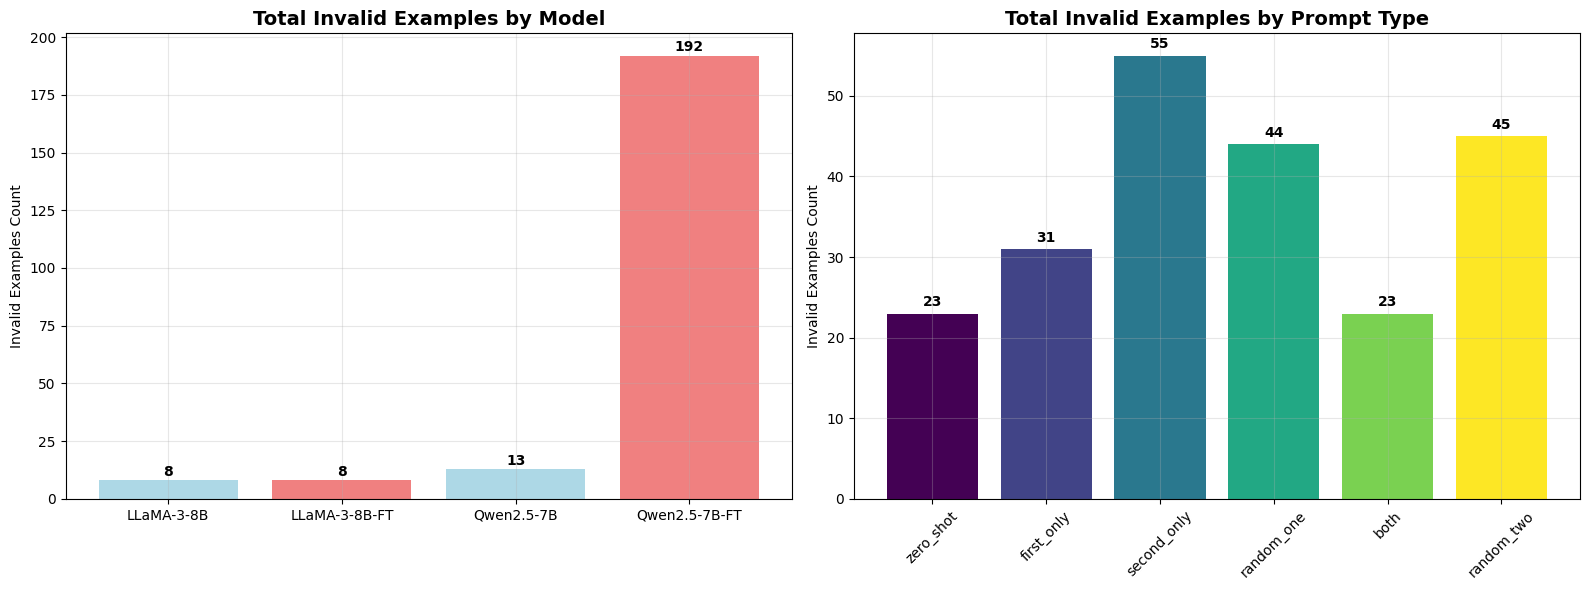


Key Insights:
--------------------
• Total invalid examples across all experiments: 221
• Model with most invalid examples: Qwen2.5-7B-FT (192 invalid)
• Prompt type with most invalid examples: second_only (55 invalid)

Correlation between Invalid Examples and Performance:
• all_mention_normalized: -0.335
• pair_alignment_normalized: -0.254
• answer_accuracy_normalized: 0.582


In [10]:
# Invalid examples analysis
print("Invalid Number of Examples Analysis:")
print("="*50)

# Create pivot table for invalid examples
invalid_pivot = df_all.pivot(index='model', columns='prompt_type', values='invalid_number_of_examples')
print("\nInvalid Examples Count by Model and Prompt Type:")
print(invalid_pivot)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot by model
invalid_by_model = df_all.groupby('model')['invalid_number_of_examples'].sum()
ax1.bar(invalid_by_model.index, invalid_by_model.values, color=['lightblue', 'lightcoral'])
ax1.set_title('Total Invalid Examples by Model', fontsize=14, fontweight='bold')
ax1.set_ylabel('Invalid Examples Count')
ax1.grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(invalid_by_model.values):
    ax1.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

# Bar plot by prompt type
invalid_by_prompt = df_all.groupby('prompt_type')['invalid_number_of_examples'].sum()
ax2.bar(range(len(invalid_by_prompt)), invalid_by_prompt.values, 
        color=plt.cm.viridis(np.linspace(0, 1, len(invalid_by_prompt))))
ax2.set_title('Total Invalid Examples by Prompt Type', fontsize=14, fontweight='bold')
ax2.set_ylabel('Invalid Examples Count')
ax2.set_xticks(range(len(invalid_by_prompt)))
ax2.set_xticklabels(invalid_by_prompt.index, rotation=45)
ax2.grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(invalid_by_prompt.values):
    ax2.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Analysis insights
print("\nKey Insights:")
print("-" * 20)
print(f"• Total invalid examples across all experiments: {df_all['invalid_number_of_examples'].sum()}")
print(f"• Model with most invalid examples: {invalid_by_model.idxmax()} ({invalid_by_model.max()} invalid)")
print(f"• Prompt type with most invalid examples: {invalid_by_prompt.idxmax()} ({invalid_by_prompt.max()} invalid)")

# Check if there's a correlation between invalid examples and performance
print("\nCorrelation between Invalid Examples and Performance:")
for metric in metrics_of_interest:
    correlation = df_all['invalid_number_of_examples'].corr(df_all[metric])
    print(f"• {metric}: {correlation:.3f}")


## 6. Summary Statistics and Heatmaps

Overall performance summary with heatmap visualizations.


Summary Statistics:
       all_mention_normalized  pair_alignment_normalized  \
count               24.000000                  24.000000   
mean                 0.204564                   0.121065   
std                  0.115074                   0.075627   
min                  0.017211                   0.008826   
25%                  0.122904                   0.071050   
50%                  0.187555                   0.109885   
75%                  0.259378                   0.157105   
max                  0.458076                   0.293027   

       answer_accuracy_normalized  invalid_number_of_examples  
count                   24.000000                   24.000000  
mean                     0.857493                    9.208333  
std                      0.039646                   15.134123  
min                      0.796278                    1.000000  
25%                      0.829824                    1.000000  
50%                      0.856024                    1.

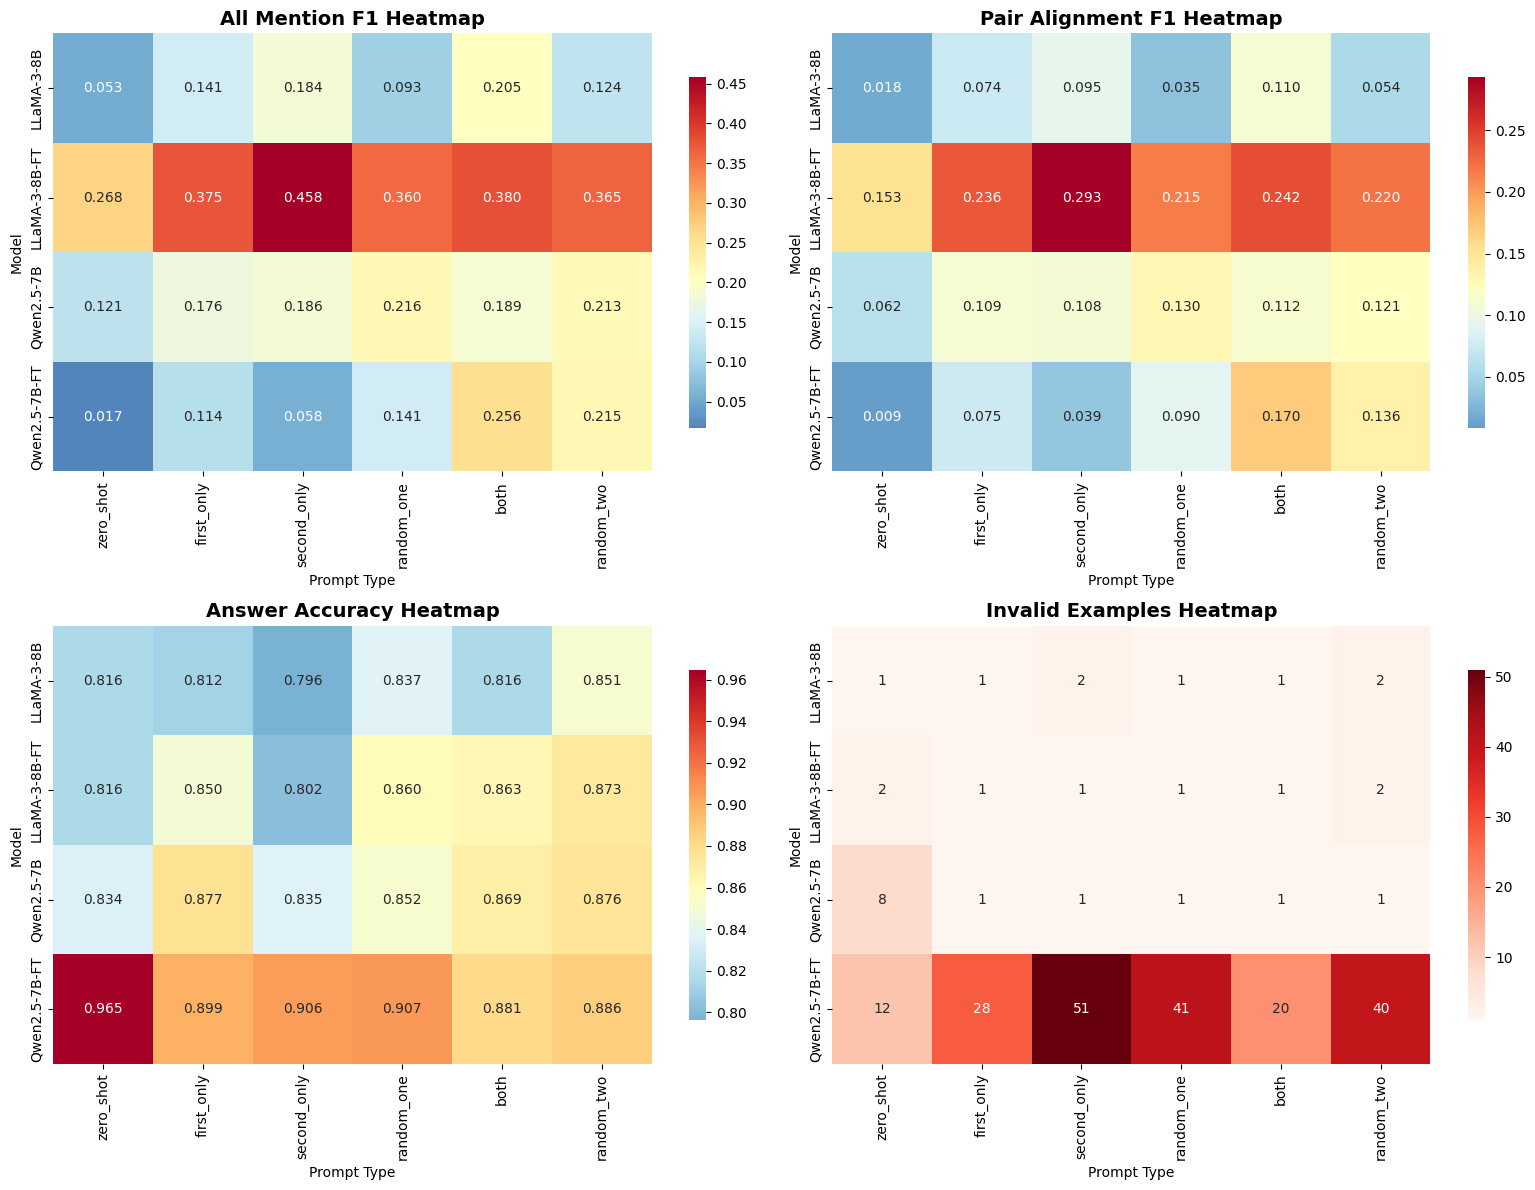


Best Performance by Metric:

All Mention F1:
  Best: LLaMA-3-8B-FT with second_only
  Score: 0.458

Pair Alignment F1:
  Best: LLaMA-3-8B-FT with second_only
  Score: 0.293

Answer Accuracy:
  Best: Qwen2.5-7B-FT with zero_shot
  Score: 0.965

Overall Analysis:
Best overall configuration: LLaMA-3-8B-FT with second_only
Average score: 0.518

Model Comparison (average across all prompt types):
               all_mention_normalized  pair_alignment_normalized  \
model                                                              
LLaMA-3-8B                   0.133274                   0.064431   
LLaMA-3-8B-FT                0.367755                   0.226390   
Qwen2.5-7B                   0.183510                   0.106943   
Qwen2.5-7B-FT                0.133716                   0.086496   

               answer_accuracy_normalized  average_performance  
model                                                           
LLaMA-3-8B                       0.821417             0.339707  


In [11]:
# Summary statistics
print("Summary Statistics:")
print("="*30)
print(df_all[metrics_of_interest + ['invalid_number_of_examples']].describe())

# Create heatmaps for each metric
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()  # Flatten the array for easier indexing

for idx, metric in enumerate(metrics_of_interest):
    ax = axes[idx]
    
    # Create pivot table for heatmap
    heatmap_data = df_all.pivot(index='model', columns='prompt_type', values=metric)
    
    # Create heatmap
    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlBu_r', 
                center=heatmap_data.values.mean(), ax=ax, cbar_kws={'shrink': 0.8})
    
    ax.set_title(f'{metric_names[metric]} Heatmap', fontsize=14, fontweight='bold')
    ax.set_xlabel('Prompt Type')
    ax.set_ylabel('Model')

# Invalid examples heatmap
ax = axes[3]
invalid_heatmap_data = df_all.pivot(index='model', columns='prompt_type', values='invalid_number_of_examples')
sns.heatmap(invalid_heatmap_data, annot=True, fmt='d', cmap='Reds', ax=ax, cbar_kws={'shrink': 0.8})
ax.set_title('Invalid Examples Heatmap', fontsize=14, fontweight='bold')
ax.set_xlabel('Prompt Type')
ax.set_ylabel('Model')

plt.tight_layout()
plt.show()

# Performance ranking
print("\nBest Performance by Metric:")
print("="*35)

for metric in metrics_of_interest:
    best_performance = df_all.loc[df_all[metric].idxmax()]
    print(f"\n{metric_names[metric]}:")
    print(f"  Best: {best_performance['model']} with {best_performance['prompt_type']}")
    print(f"  Score: {best_performance[metric]:.3f}")

# Overall best configurations
print("\nOverall Analysis:")
print("="*20)

# Calculate average performance across all metrics for each configuration
df_all['average_performance'] = df_all[metrics_of_interest].mean(axis=1)
best_overall = df_all.loc[df_all['average_performance'].idxmax()]

print(f"Best overall configuration: {best_overall['model']} with {best_overall['prompt_type']}")
print(f"Average score: {best_overall['average_performance']:.3f}")

# Model comparison
print(f"\nModel Comparison (average across all prompt types):")
model_avg = df_all.groupby('model')[metrics_of_interest + ['average_performance']].mean()
print(model_avg)


## 7. Prediction Quality Analysis

Deep dive into prediction accuracy using ground truth annotations from the QED dev set.


In [12]:
import jsonlines
from collections import defaultdict
import matplotlib.patches as patches

def load_ground_truth_annotations():
    """Load ground truth annotations from qed-dev.jsonlines"""
    gt_file_path = Path('../qed_data/qed-dev.jsonlines')
    
    if not gt_file_path.exists():
        print(f"Warning: Ground truth file not found: {gt_file_path}")
        return {}
    
    gt_annotations = {}
    try:
        with jsonlines.open(gt_file_path) as reader:
            for obj in reader:
                example_id = obj.get('example_id')
                if example_id and 'annotation' in obj:
                    gt_annotations[example_id] = obj['annotation']
        print(f"Loaded {len(gt_annotations)} ground truth annotations")
    except Exception as e:
        print(f"Error loading ground truth: {e}")
        return {}
    
    return gt_annotations

def has_valid_qed_annotation(annotation):
    """
    Returns True if annotation has all required QED fields with valid content.
    Checks for:
    - 'answer' field with at least one non-empty answer
    - 'selected_sentence' field with non-empty content
    - 'referential_equalities' field (can be empty list)
    """
    if not isinstance(annotation, dict):
        return False
    
    # Check for required fields
    required_fields = ["answer", "selected_sentence", "referential_equalities"]
    if not all(field in annotation for field in required_fields):
        return False
    
    # Check answer field - should have at least one non-empty answer
    answer = annotation["answer"]
    if isinstance(answer, list):
        if not answer or not any(ans.get("sentence_reference", {}).get("string", "").strip() for ans in answer):
            return False
    elif isinstance(answer, str):
        if not answer.strip():
            return False
    else:
        return False
    
    # Check selected_sentence field - should be non-empty
    selected_sentence = annotation["selected_sentence"]
    if isinstance(selected_sentence, dict):
        if not selected_sentence.get("string", "").strip():
            return False
    elif isinstance(selected_sentence, str):
        if not selected_sentence.strip():
            return False
    else:
        return False
    
    # Check referential_equalities field - should be a list (can be empty)
    if not isinstance(annotation["referential_equalities"], list):
        return False
    
    return True

def load_detailed_predictions(model_path, prompt_type):
    """Load detailed predictions from jsonlines file"""
    file_path = base_path / model_path / prompt_type / 'detailed_predictions.jsonlines'
    
    if not file_path.exists():
        print(f"Warning: File not found: {file_path}")
        return []
    
    predictions = []
    try:
        with jsonlines.open(file_path) as reader:
            for obj in reader:
                predictions.append(obj)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return []
    
    return predictions

def extract_length_statistics(predictions, gt_annotations):
    """Extract length statistics from predictions using ground truth annotations"""
    stats = {
        'answer_lengths_pred': [],
        'answer_lengths_actual': [],
        'question_ref_lengths_pred': [],
        'question_ref_lengths_actual': [],
        'sentence_ref_lengths_pred': [],
        'sentence_ref_lengths_actual': [],
        'ref_eq_count_pred': [],
        'ref_eq_count_actual': []
    }
    
    valid_count = 0
    total_count = 0
    
    for pred in predictions:
        total_count += 1
        example_id = pred.get('example_id')
        
        # Skip if we don't have ground truth for this example
        if example_id not in gt_annotations:
            continue
            
        gt_annotation = gt_annotations[example_id]
        
        # Skip if ground truth annotation is not valid
        if not has_valid_qed_annotation(gt_annotation):
            continue
            
        valid_count += 1
        
        try:
            # Extract predicted answer lengths
            if 'annotation' in pred and 'answer' in pred['annotation']:
                pred_answers = pred['annotation']['answer']
                for answer in pred_answers:
                    if 'sentence_reference' in answer and 'string' in answer['sentence_reference']:
                        stats['answer_lengths_pred'].append(len(answer['sentence_reference']['string']))
            
            # Extract actual answer lengths from ground truth
            gt_answers = gt_annotation['answer']
            if isinstance(gt_answers, list):
                for answer in gt_answers:
                    if 'sentence_reference' in answer and 'string' in answer['sentence_reference']:
                        stats['answer_lengths_actual'].append(len(answer['sentence_reference']['string']))
            
            # Extract predicted referential equalities statistics
            if 'annotation' in pred and 'referential_equalities' in pred['annotation']:
                pred_ref_eqs = pred['annotation']['referential_equalities']
                stats['ref_eq_count_pred'].append(len(pred_ref_eqs))
                
                for ref_eq in pred_ref_eqs:
                    if 'question_reference' in ref_eq and 'string' in ref_eq['question_reference']:
                        stats['question_ref_lengths_pred'].append(len(ref_eq['question_reference']['string']))
                    if 'sentence_reference' in ref_eq and 'string' in ref_eq['sentence_reference']:
                        stats['sentence_ref_lengths_pred'].append(len(ref_eq['sentence_reference']['string']))
            else:
                # If no predicted referential equalities, add 0
                stats['ref_eq_count_pred'].append(0)
            
            # Extract actual referential equalities statistics from ground truth
            gt_ref_eqs = gt_annotation['referential_equalities']
            stats['ref_eq_count_actual'].append(len(gt_ref_eqs))
            
            for ref_eq in gt_ref_eqs:
                if 'question_reference' in ref_eq and 'string' in ref_eq['question_reference']:
                    stats['question_ref_lengths_actual'].append(len(ref_eq['question_reference']['string']))
                if 'sentence_reference' in ref_eq and 'string' in ref_eq['sentence_reference']:
                    stats['sentence_ref_lengths_actual'].append(len(ref_eq['sentence_reference']['string']))
                    
        except Exception as e:
            print(f"Error processing prediction {example_id}: {e}")
            continue
    
    print(f"  Processed {valid_count}/{total_count} examples with valid ground truth annotations")
    return stats

# Load ground truth annotations once
print("Loading ground truth annotations...")
gt_annotations = load_ground_truth_annotations()

# Load predictions for all model-prompt combinations
print("\nLoading detailed predictions...")
prediction_stats = {}

for model_path, model_name in models.items():
    prediction_stats[model_name] = {}
    for prompt_type in prompt_types:
        print(f"Loading {model_name} - {prompt_type}...")
        predictions = load_detailed_predictions(model_path, prompt_type)
        stats = extract_length_statistics(predictions, gt_annotations)
        prediction_stats[model_name][prompt_type] = stats
        print(f"  Loaded {len(predictions)} predictions")

print("✅ Finished loading predictions!")

Loading ground truth annotations...
Loaded 1355 ground truth annotations

Loading detailed predictions...
Loading LLaMA-3-8B - zero_shot...
  Processed 1020/1020 examples with valid ground truth annotations
  Loaded 1020 predictions
Loading LLaMA-3-8B - first_only...
  Processed 1020/1020 examples with valid ground truth annotations
  Loaded 1020 predictions
Loading LLaMA-3-8B - second_only...
  Processed 1019/1019 examples with valid ground truth annotations
  Loaded 1019 predictions
Loading LLaMA-3-8B - random_one...
  Processed 2040/2040 examples with valid ground truth annotations
  Loaded 2040 predictions
Loading LLaMA-3-8B - both...
  Processed 1020/1020 examples with valid ground truth annotations
  Loaded 1020 predictions
Loading LLaMA-3-8B - random_two...
  Processed 1019/1019 examples with valid ground truth annotations
  Loaded 1019 predictions
Loading Qwen2.5-7B - zero_shot...
  Processed 1013/1013 examples with valid ground truth annotations
  Loaded 1013 predictions
Loadi

In [13]:
### 5.1 Answer Length Distribution Analysis

def plot_length_distributions(stat_type, title, ylabel, model_names):
    """Plot length distributions comparing predicted vs actual"""
    fig, axes = plt.subplots(len(model_names), len(prompt_types), figsize=(24, 12))
    fig.suptitle(f'{title} - Predicted vs Actual Distributions', fontsize=16, fontweight='bold')
    
    for i, model_name in enumerate(model_names):

        for j, prompt_type in enumerate(prompt_types):
            ax = axes[i, j] if len(model_names) > 1 else axes[j]
            
            stats = prediction_stats[model_name][prompt_type]
            pred_lengths = stats[f'{stat_type}_pred']
            actual_lengths = stats[f'{stat_type}_actual']
            
            if pred_lengths and actual_lengths:
                # Create histograms
                bins = np.linspace(0, max(max(pred_lengths, default=0), max(actual_lengths, default=0)), 30)
                ax.hist(pred_lengths, bins=bins, alpha=0.6, label='Predicted', color='skyblue', density=True)
                ax.hist(actual_lengths, bins=bins, alpha=0.6, label='Actual', color='orange', density=True)
                
                # Add statistics
                pred_mean = np.mean(pred_lengths) if pred_lengths else 0
                actual_mean = np.mean(actual_lengths) if actual_lengths else 0
                ax.axvline(pred_mean, color='blue', linestyle='--', alpha=0.8, label=f'Pred Mean: {pred_mean:.1f}')
                ax.axvline(actual_mean, color='red', linestyle='--', alpha=0.8, label=f'Actual Mean: {actual_mean:.1f}')
            
            ax.set_title(f'{model_name}\n{prompt_type}', fontsize=10)
            ax.set_xlabel('Length')
            ax.set_ylabel(ylabel)
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Answer length distributions for Qwen models:


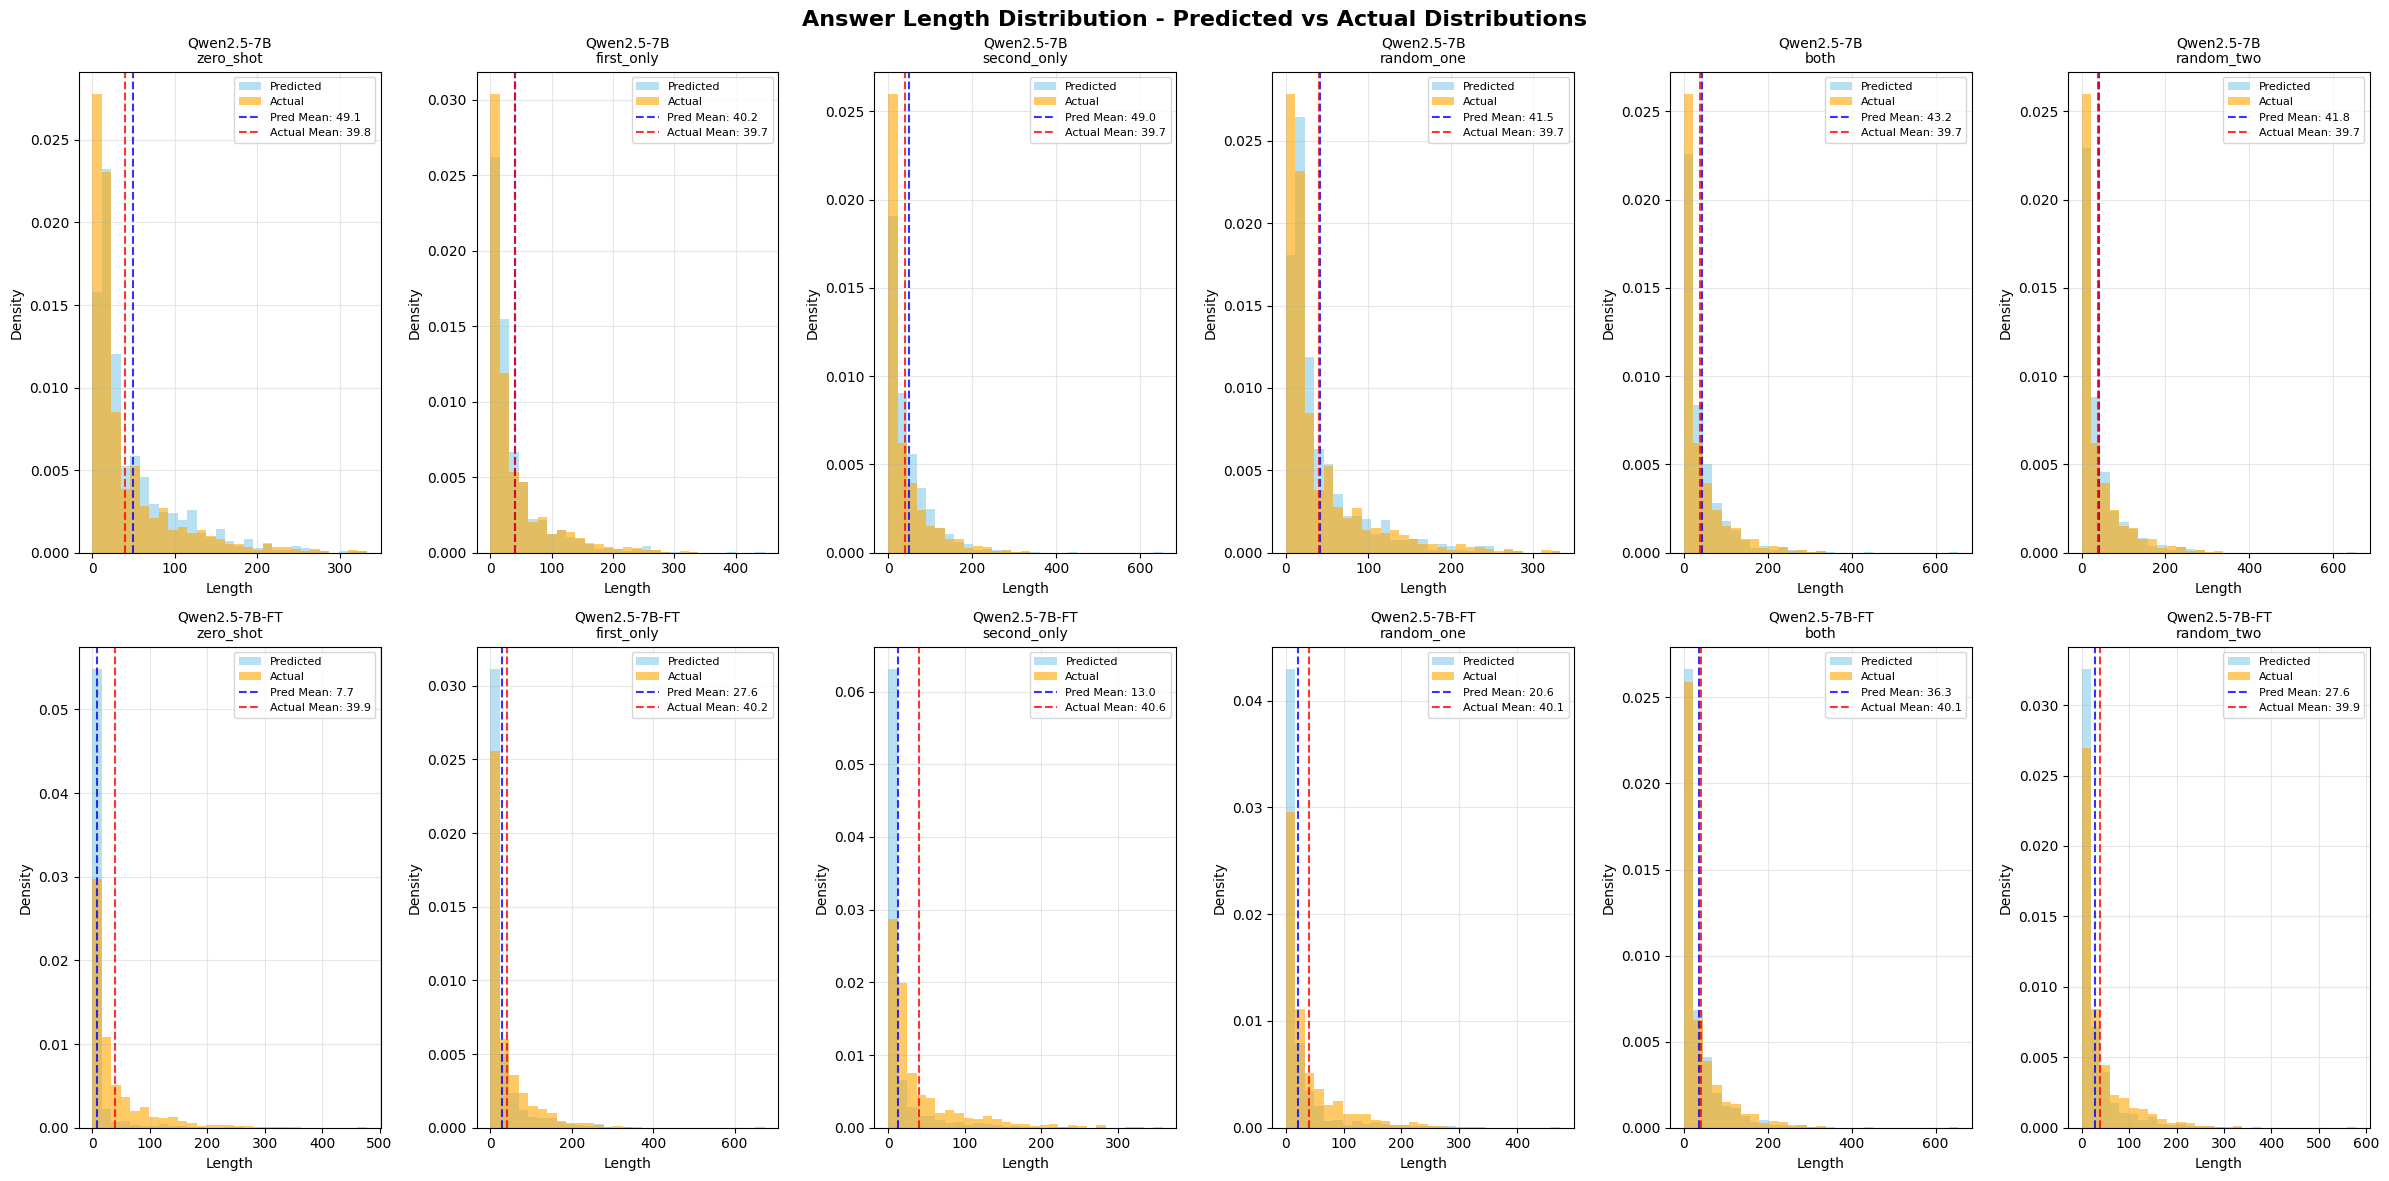

Answer length distributions for Llama models:


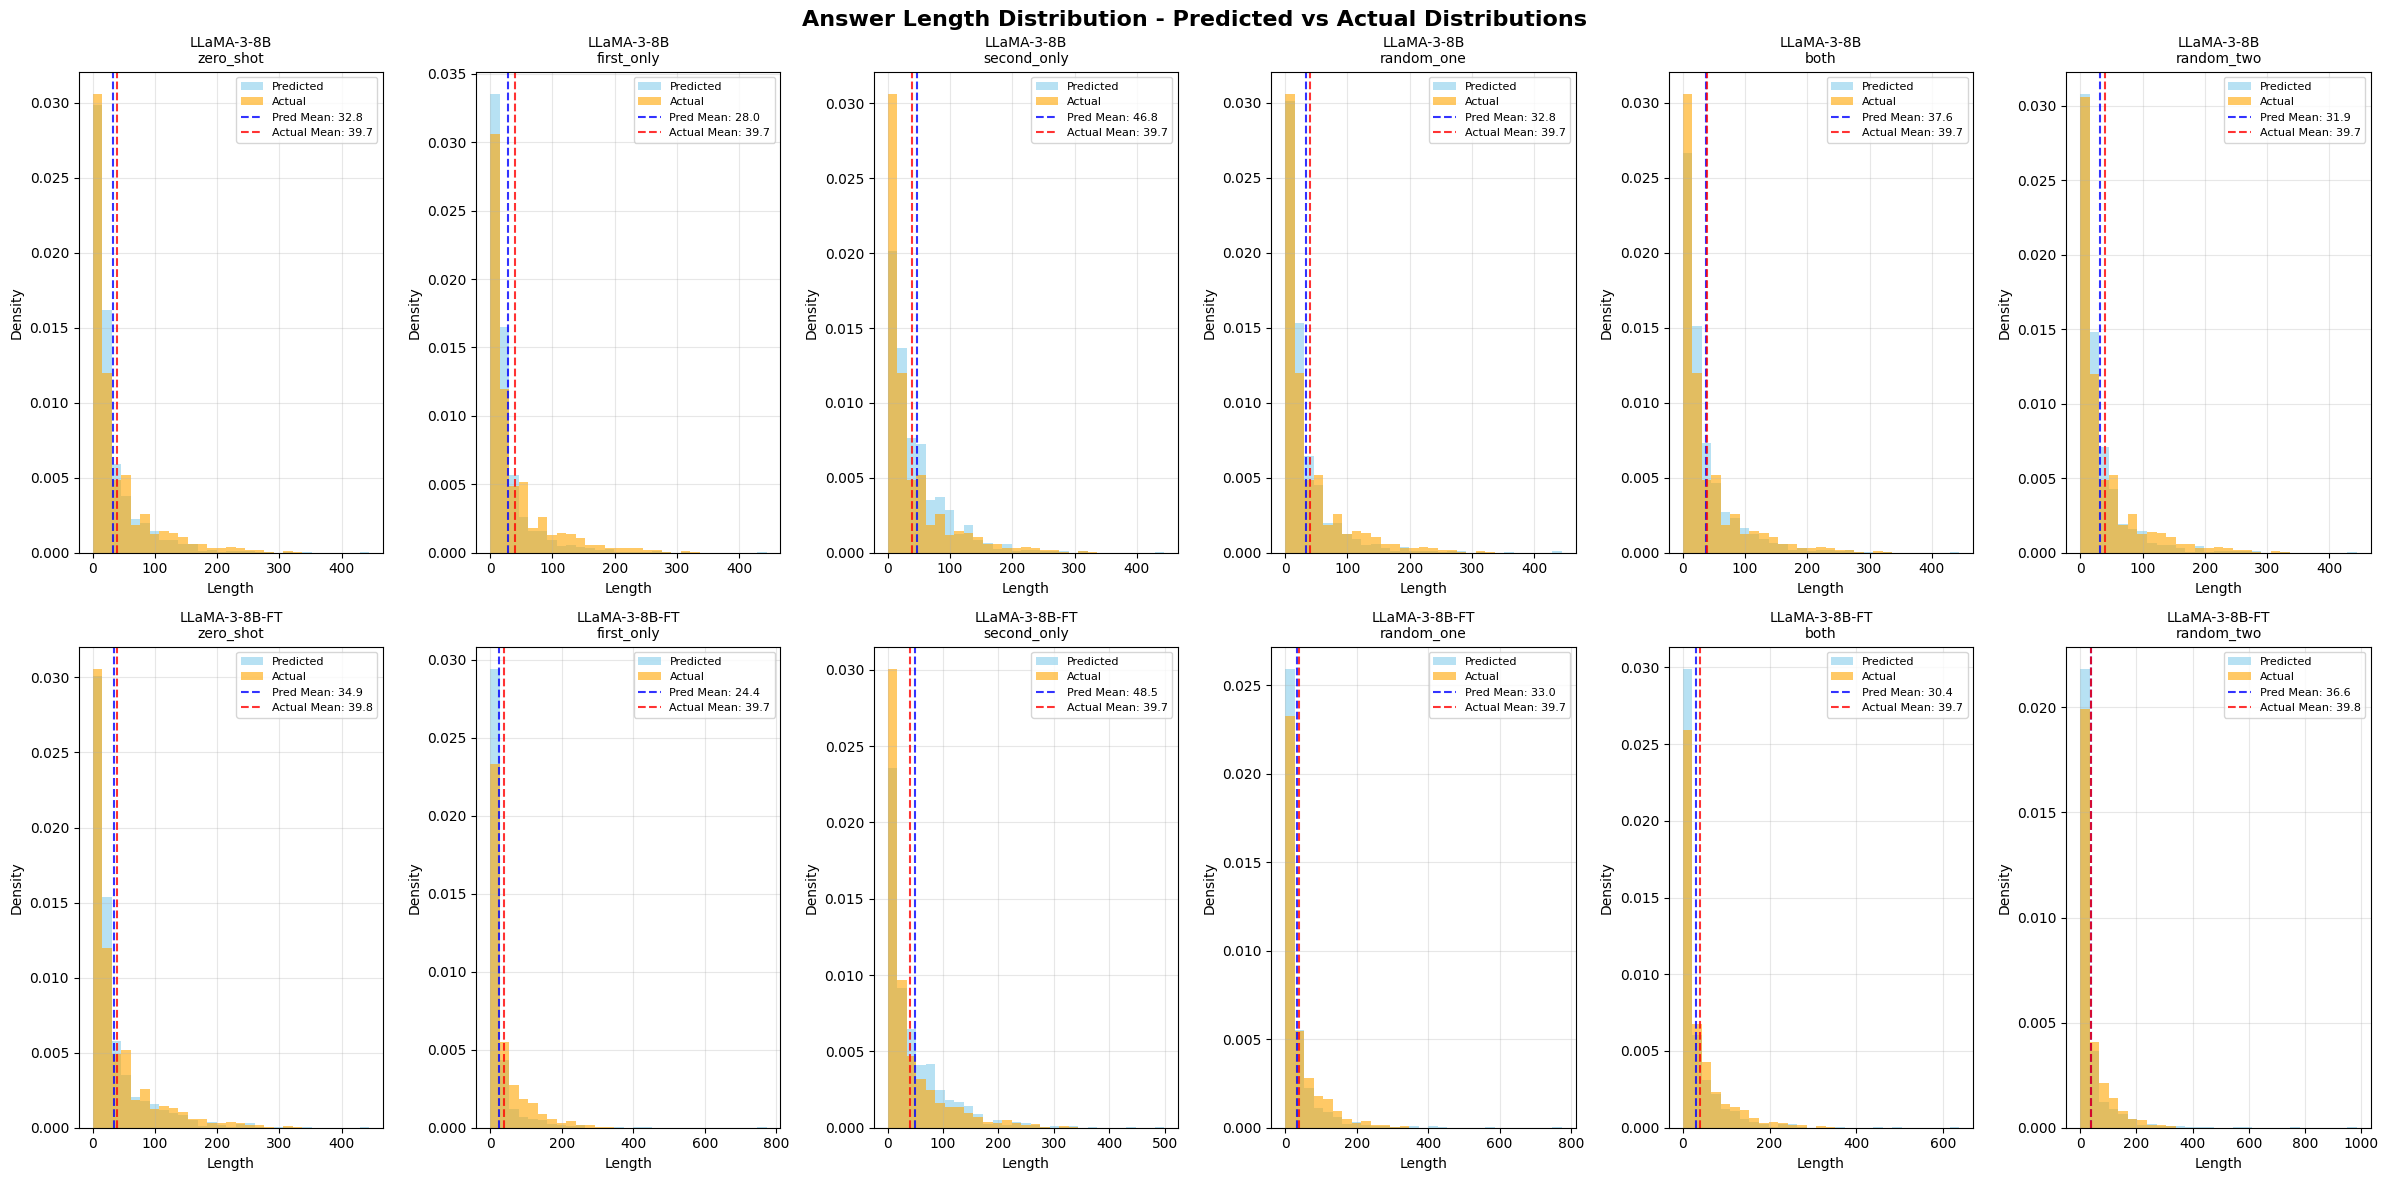

In [14]:
# Plot answer length distributions
quen_models = ['Qwen2.5-7B', 'Qwen2.5-7B-FT']
llama_models = ['LLaMA-3-8B', 'LLaMA-3-8B-FT']

print(f"Answer length distributions for Qwen models:")
plot_length_distributions('answer_lengths', 'Answer Length Distribution', 'Density', quen_models)
print(f"Answer length distributions for Llama models:")
plot_length_distributions('answer_lengths', 'Answer Length Distribution', 'Density', llama_models)



Question reference length distributions for Qwen models:


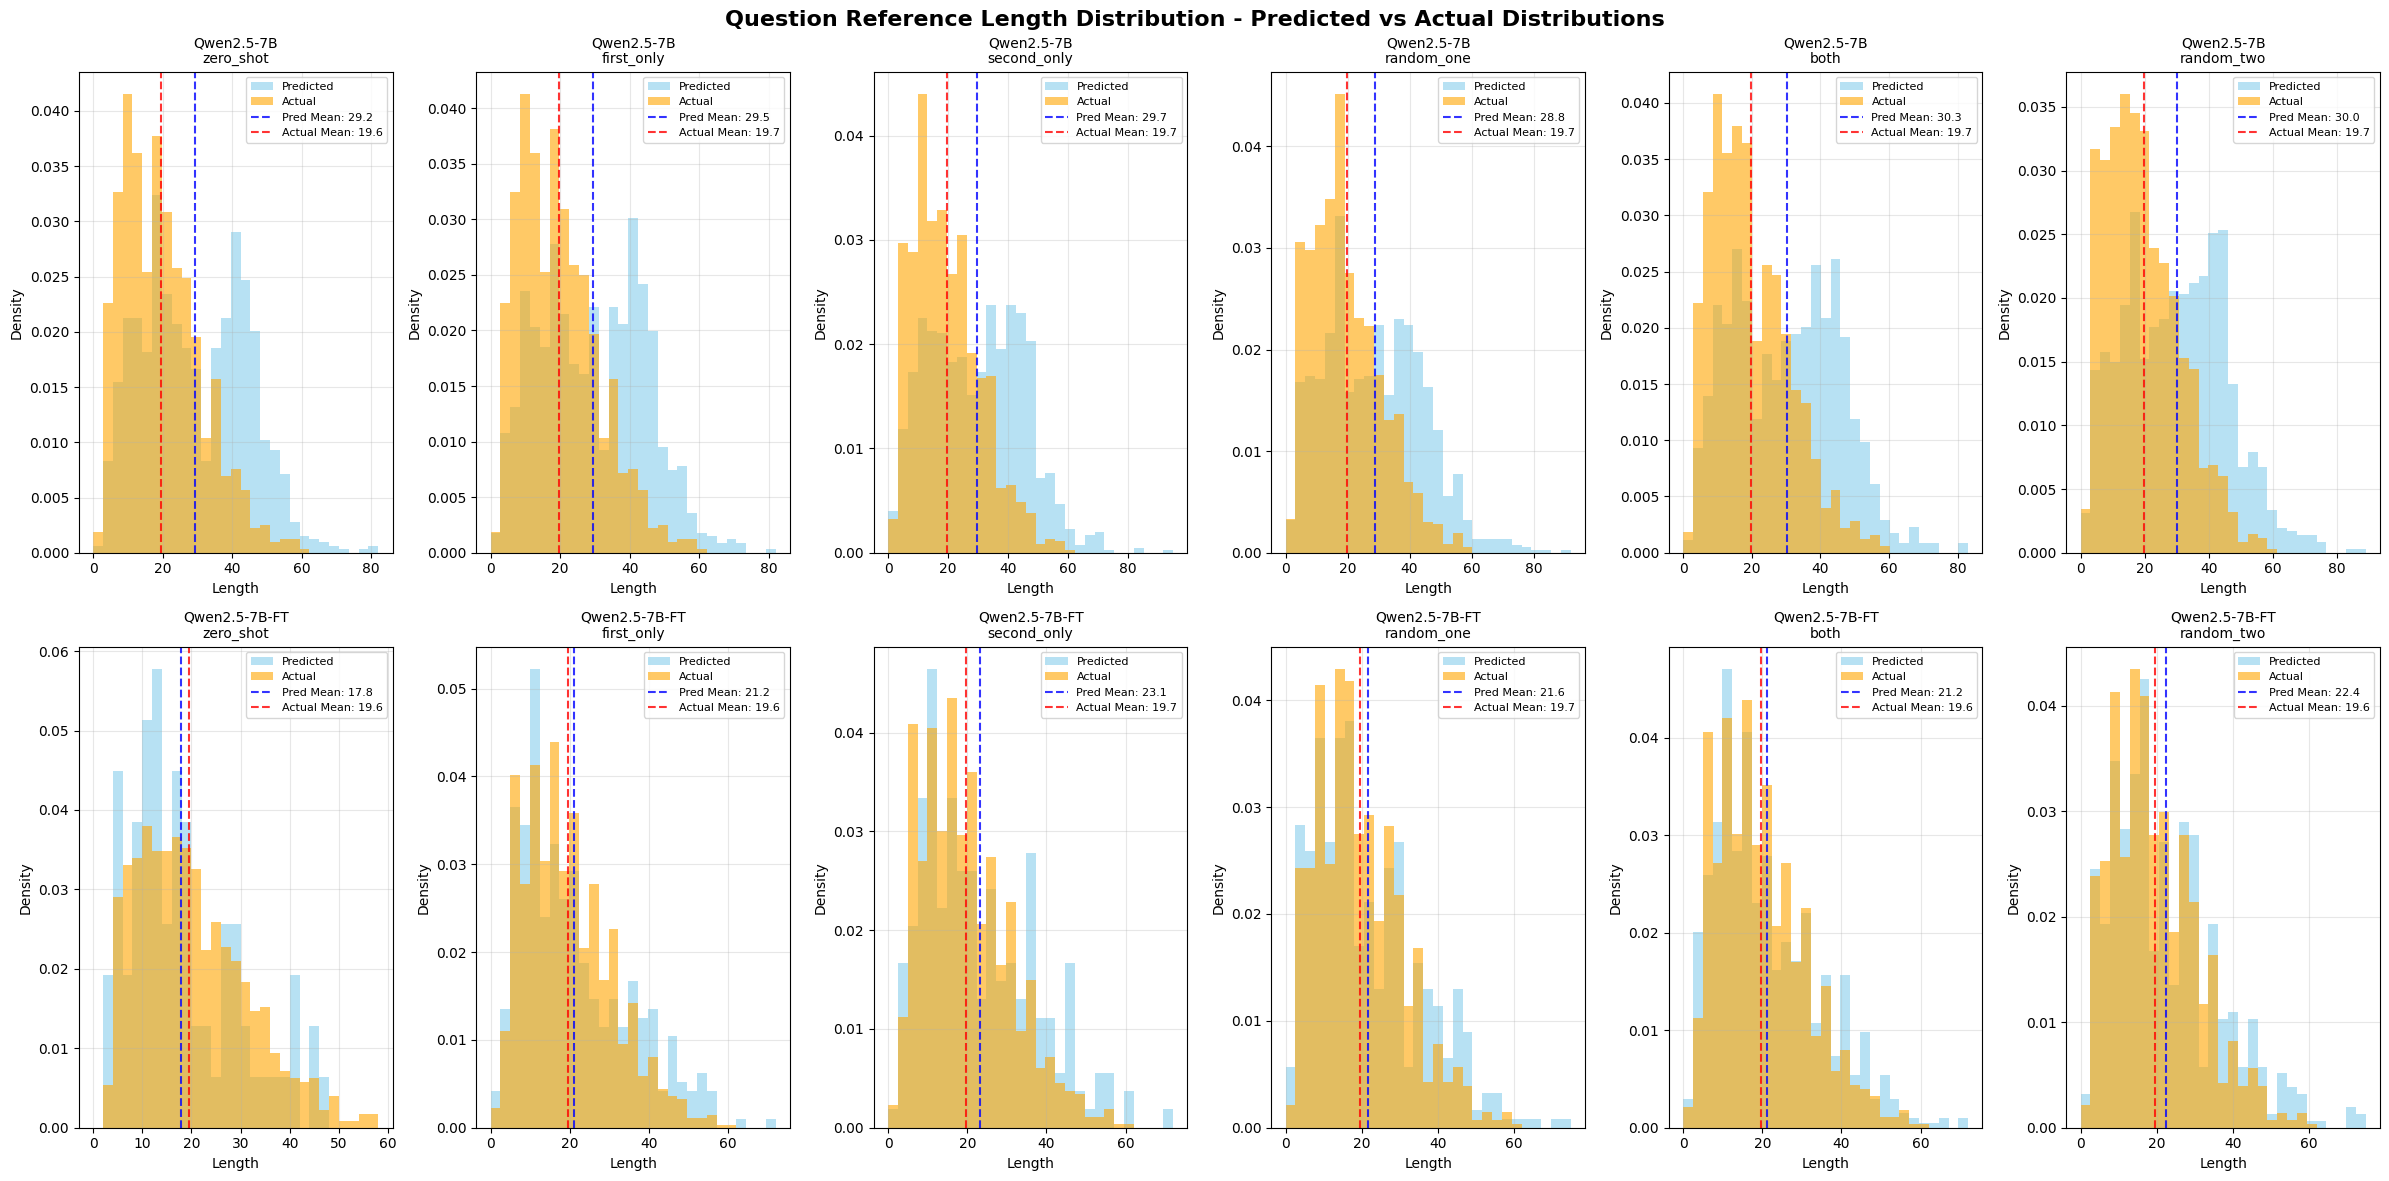

Question reference length distributions for Llama models:


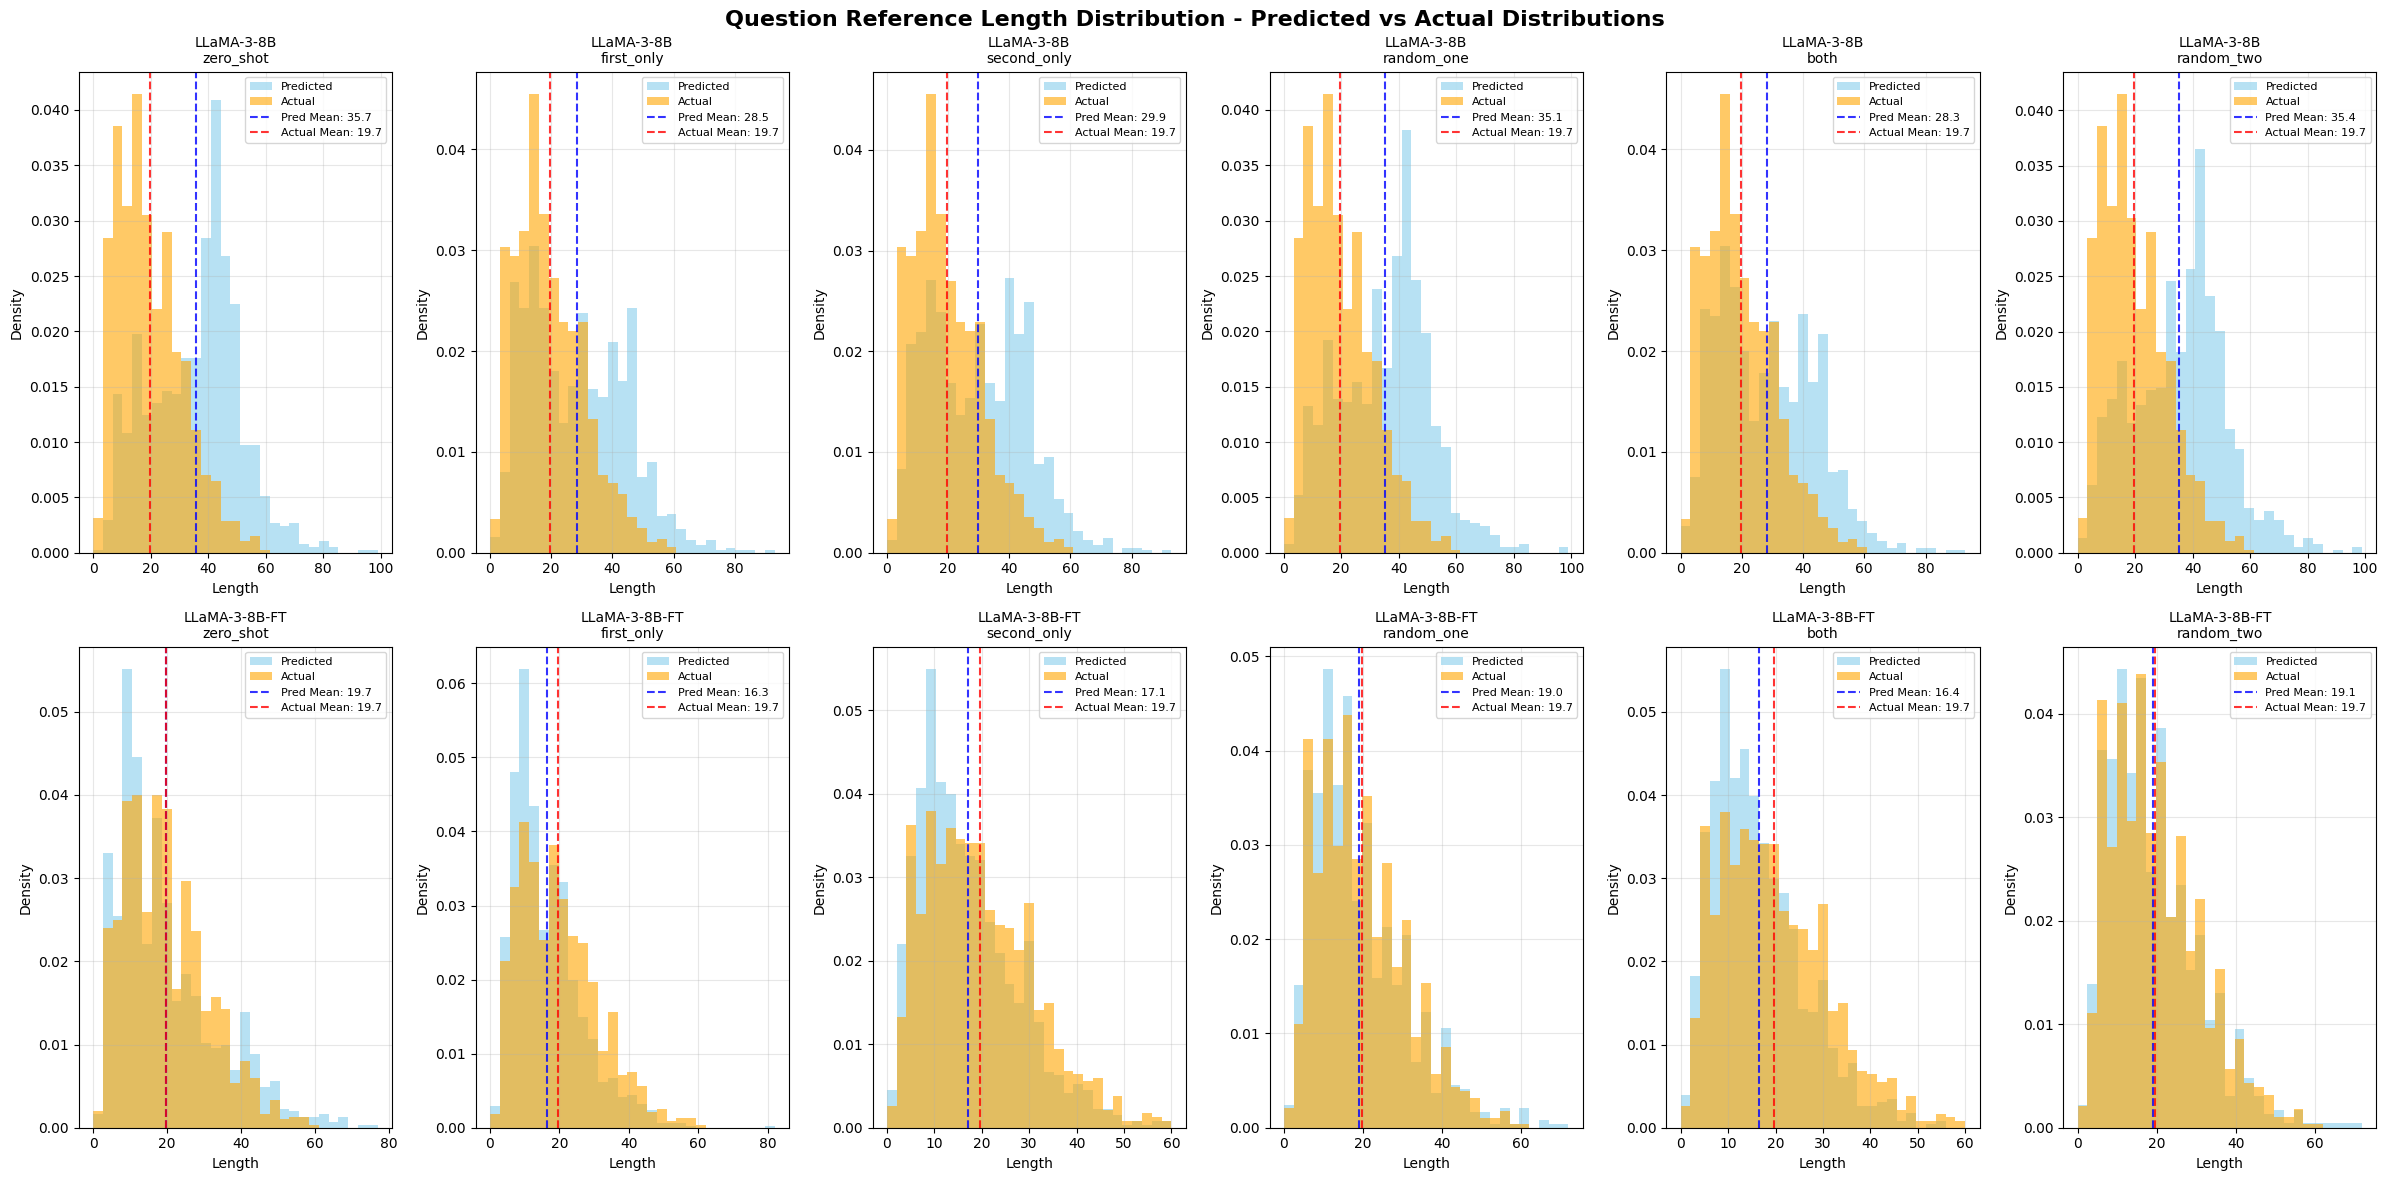

In [15]:

print(f"Question reference length distributions for Qwen models:")
plot_length_distributions('question_ref_lengths', 'Question Reference Length Distribution', 'Density', quen_models)
print(f"Question reference length distributions for Llama models:")
plot_length_distributions('question_ref_lengths', 'Question Reference Length Distribution', 'Density', llama_models)


Sentence reference length distributions for Qwen models:


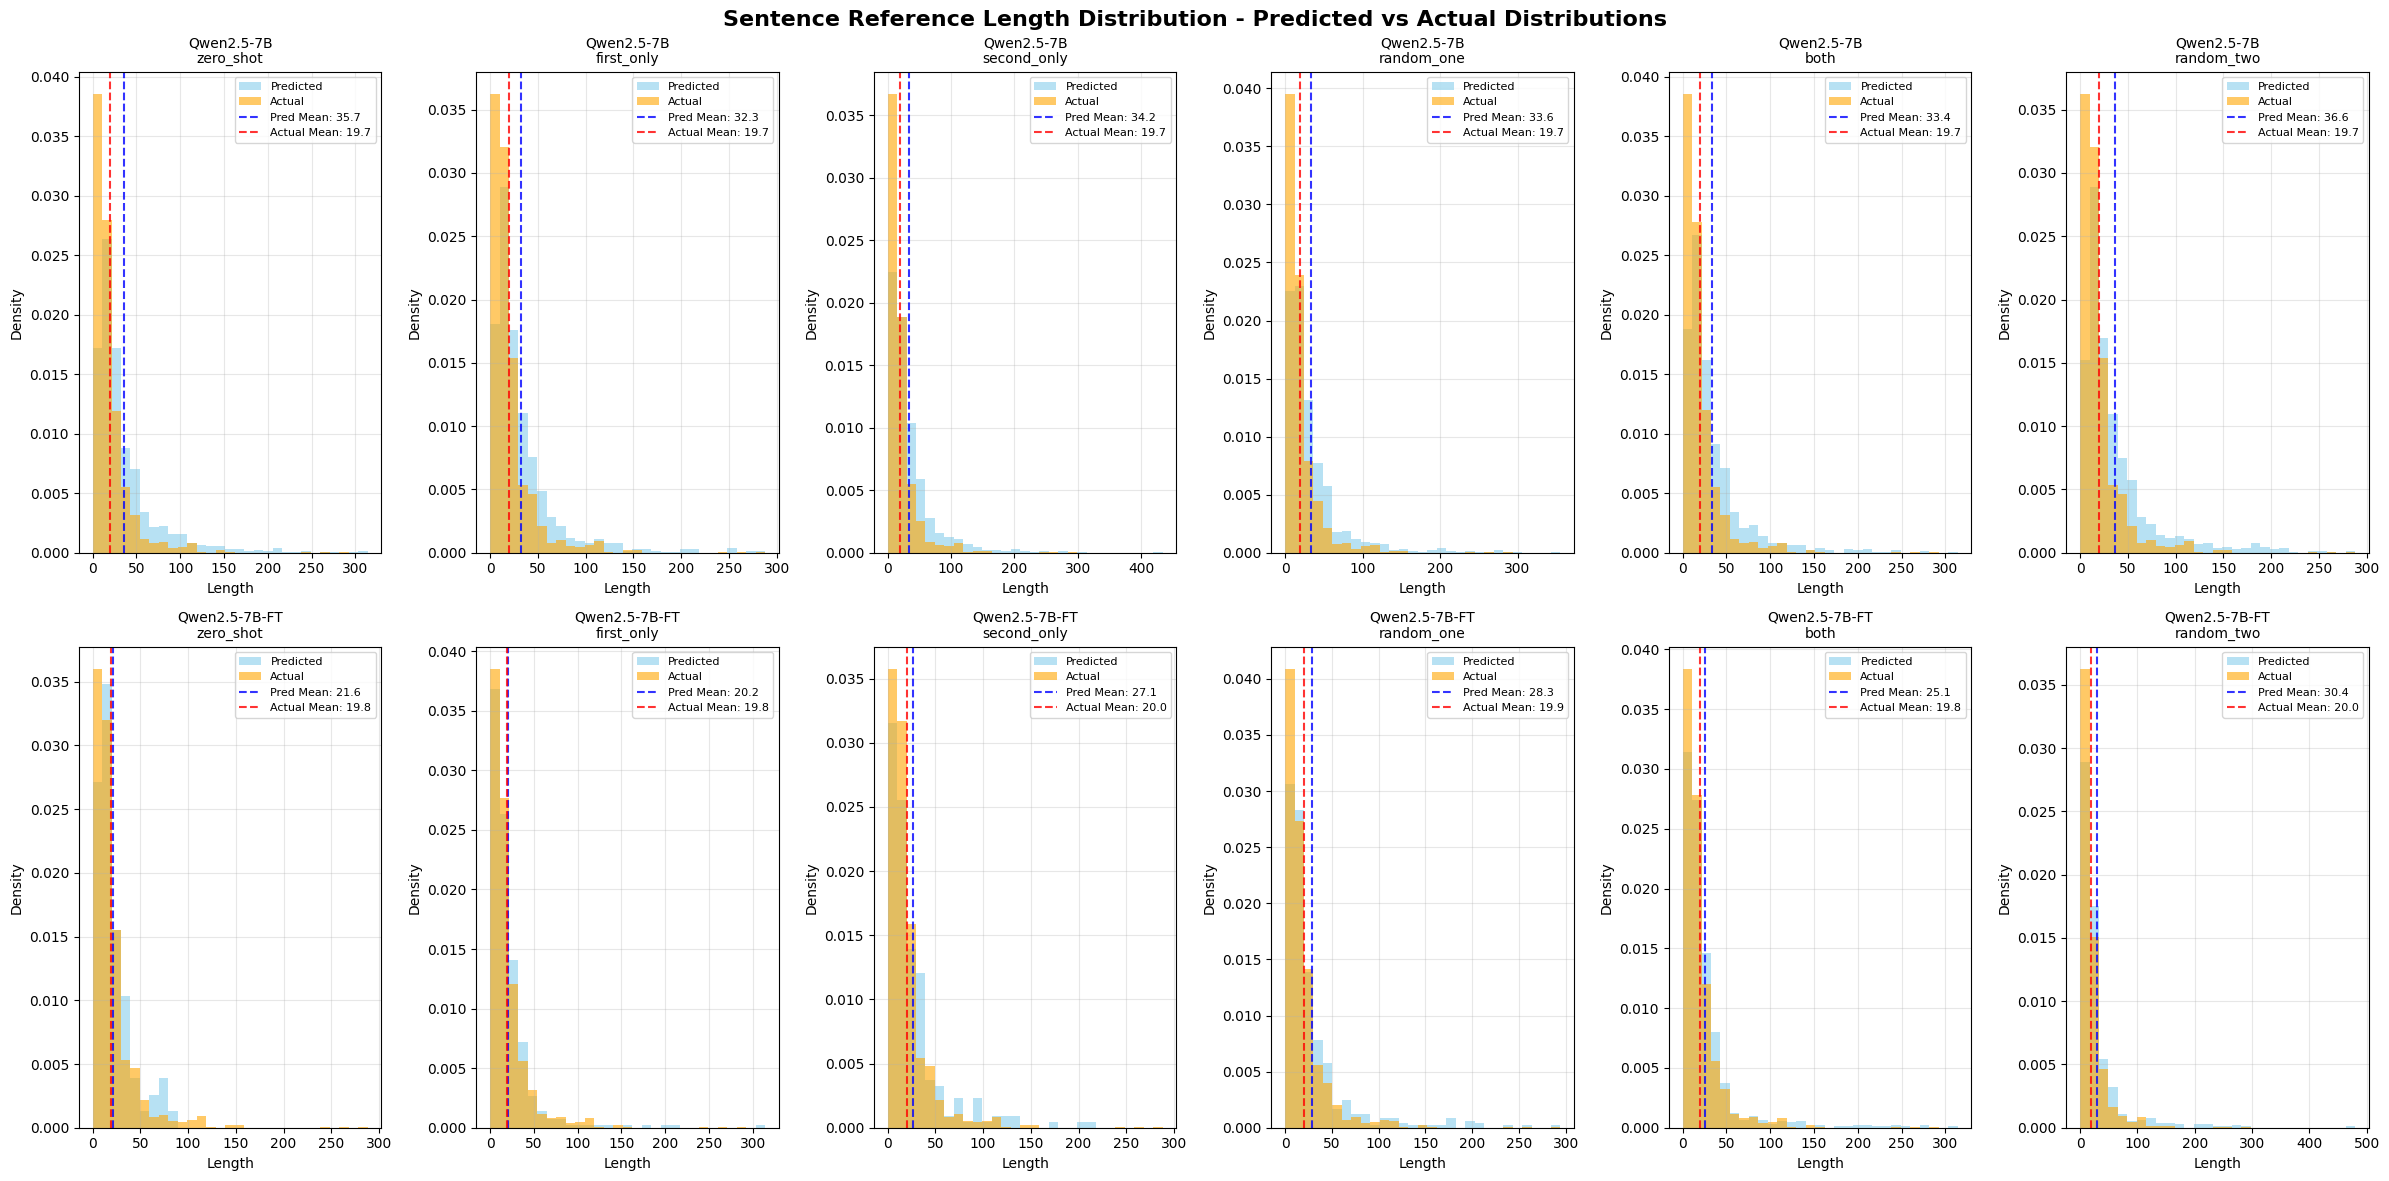

Sentence reference length distributions for Llama models:


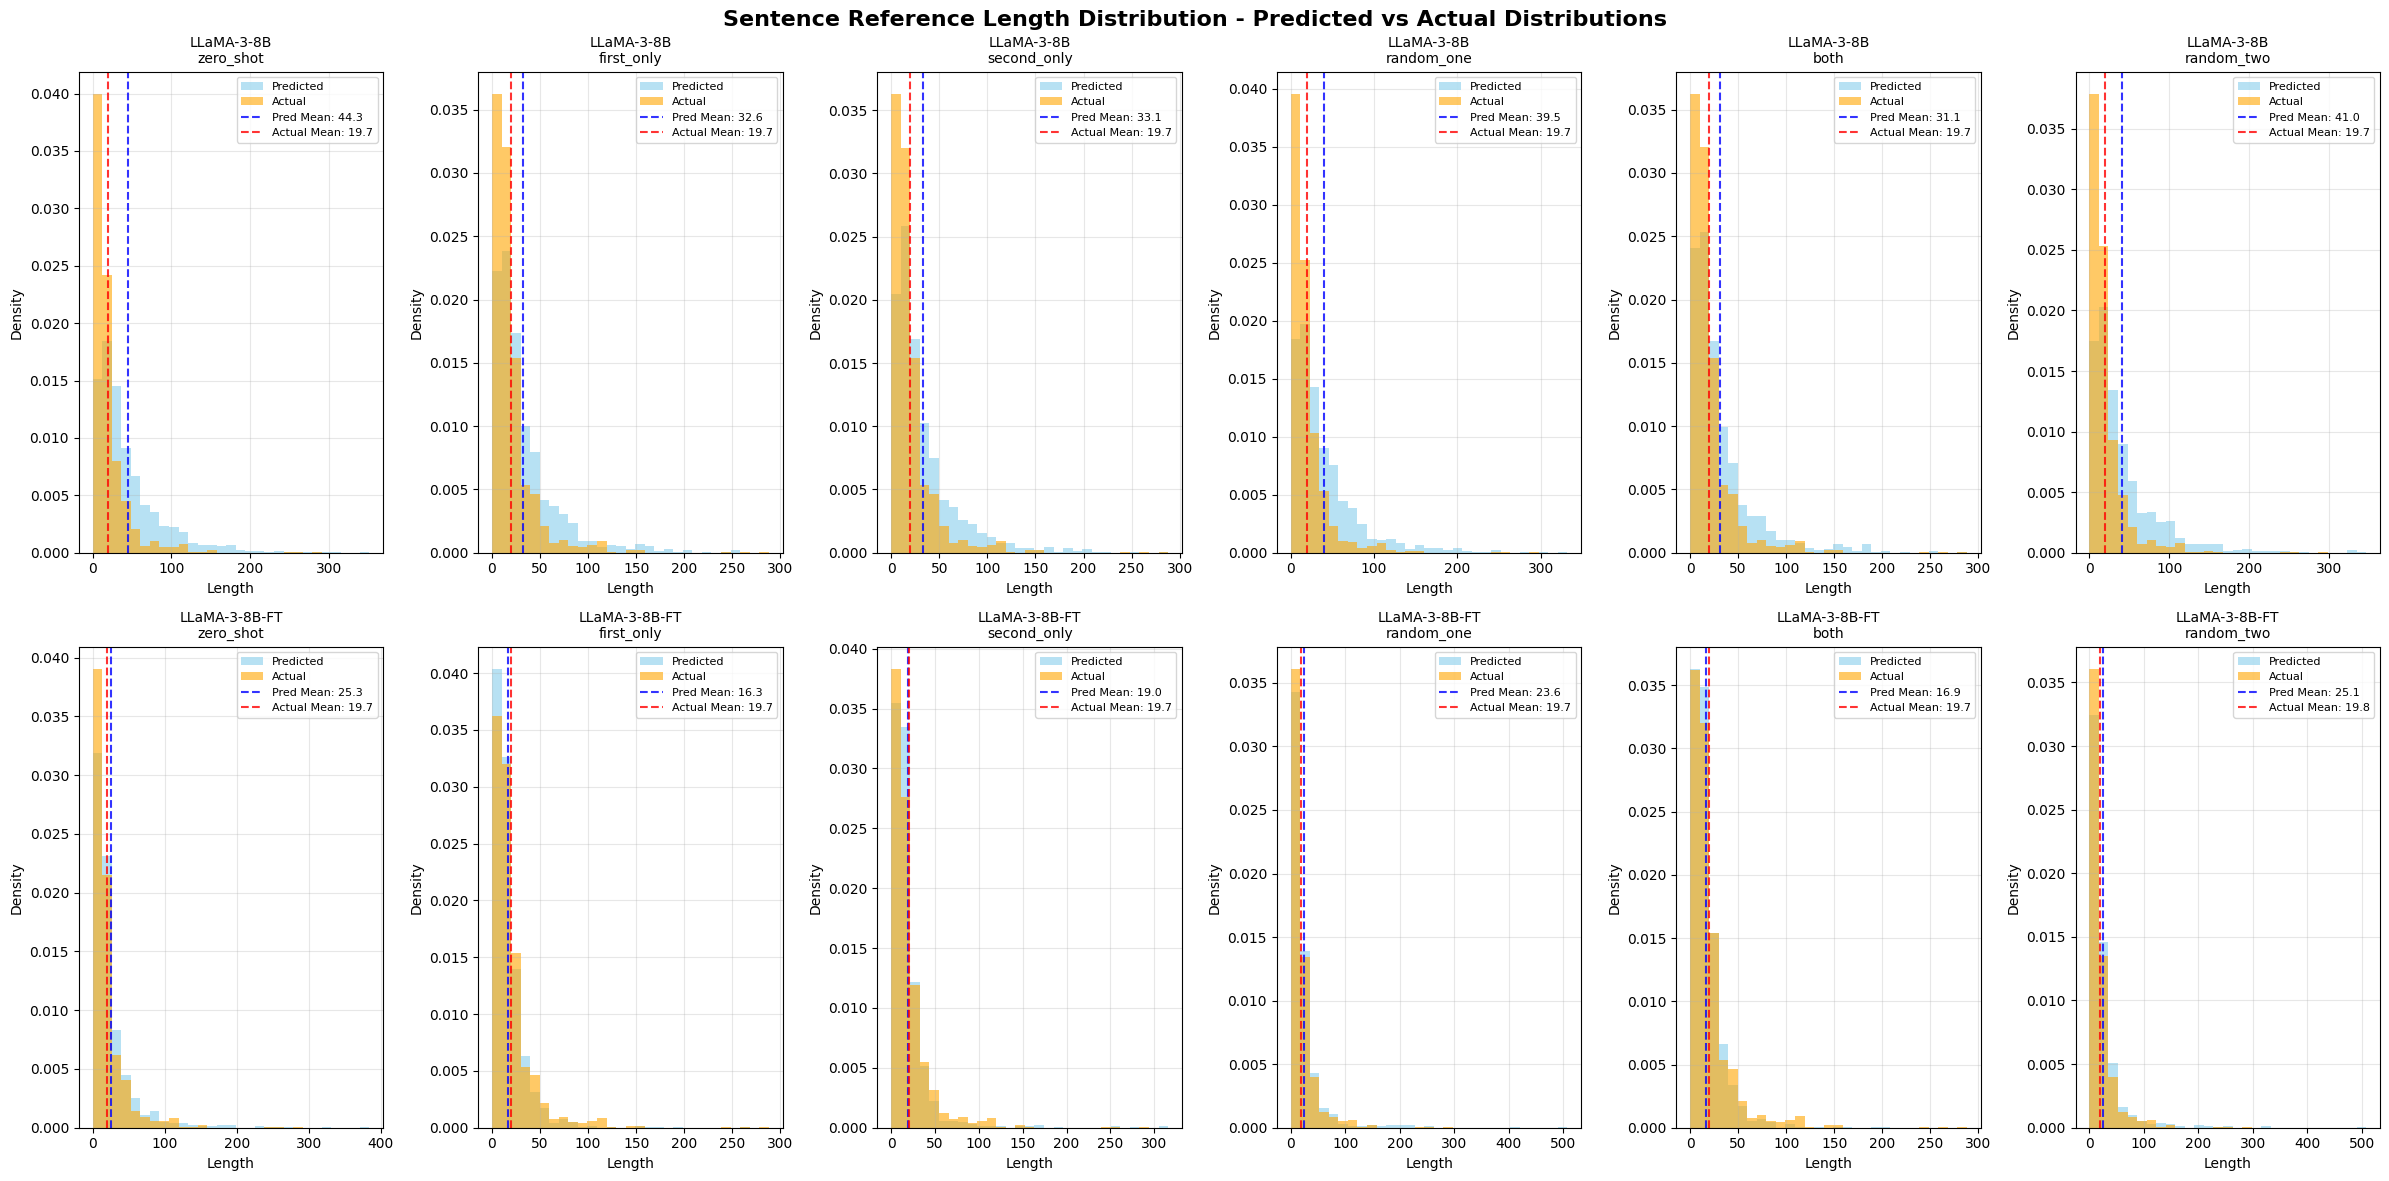

In [16]:
print(f"Sentence reference length distributions for Qwen models:")
plot_length_distributions('sentence_ref_lengths', 'Sentence Reference Length Distribution', 'Density', quen_models)
print(f"Sentence reference length distributions for Llama models:")
plot_length_distributions('sentence_ref_lengths', 'Sentence Reference Length Distribution', 'Density', llama_models)


Referential equality count distributions for Qwen models:


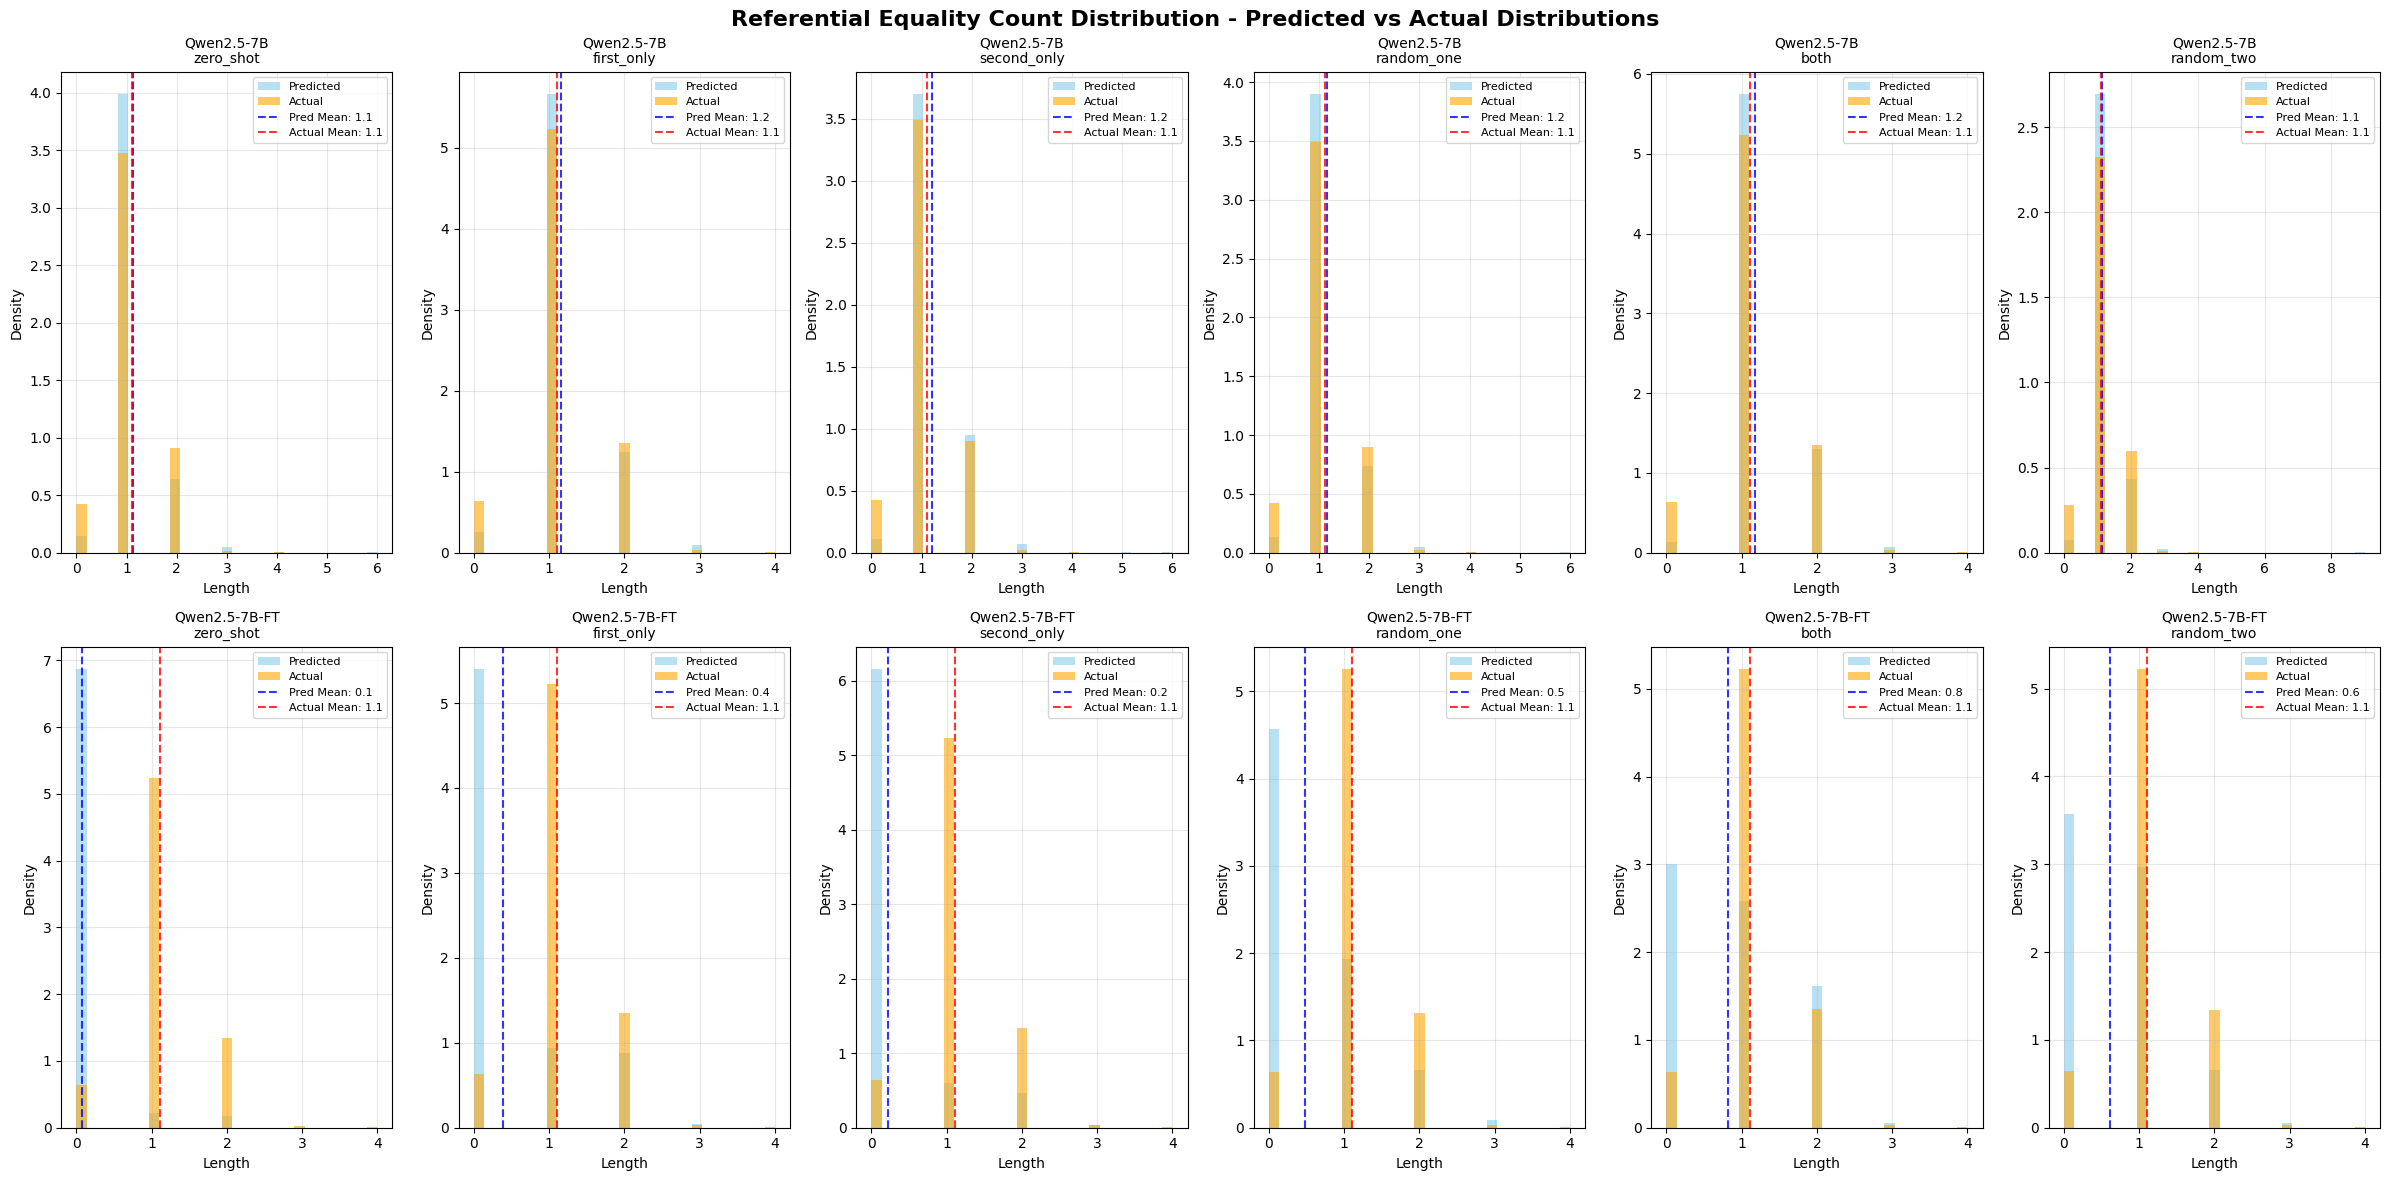

Referential equality count distributions for Llama models:


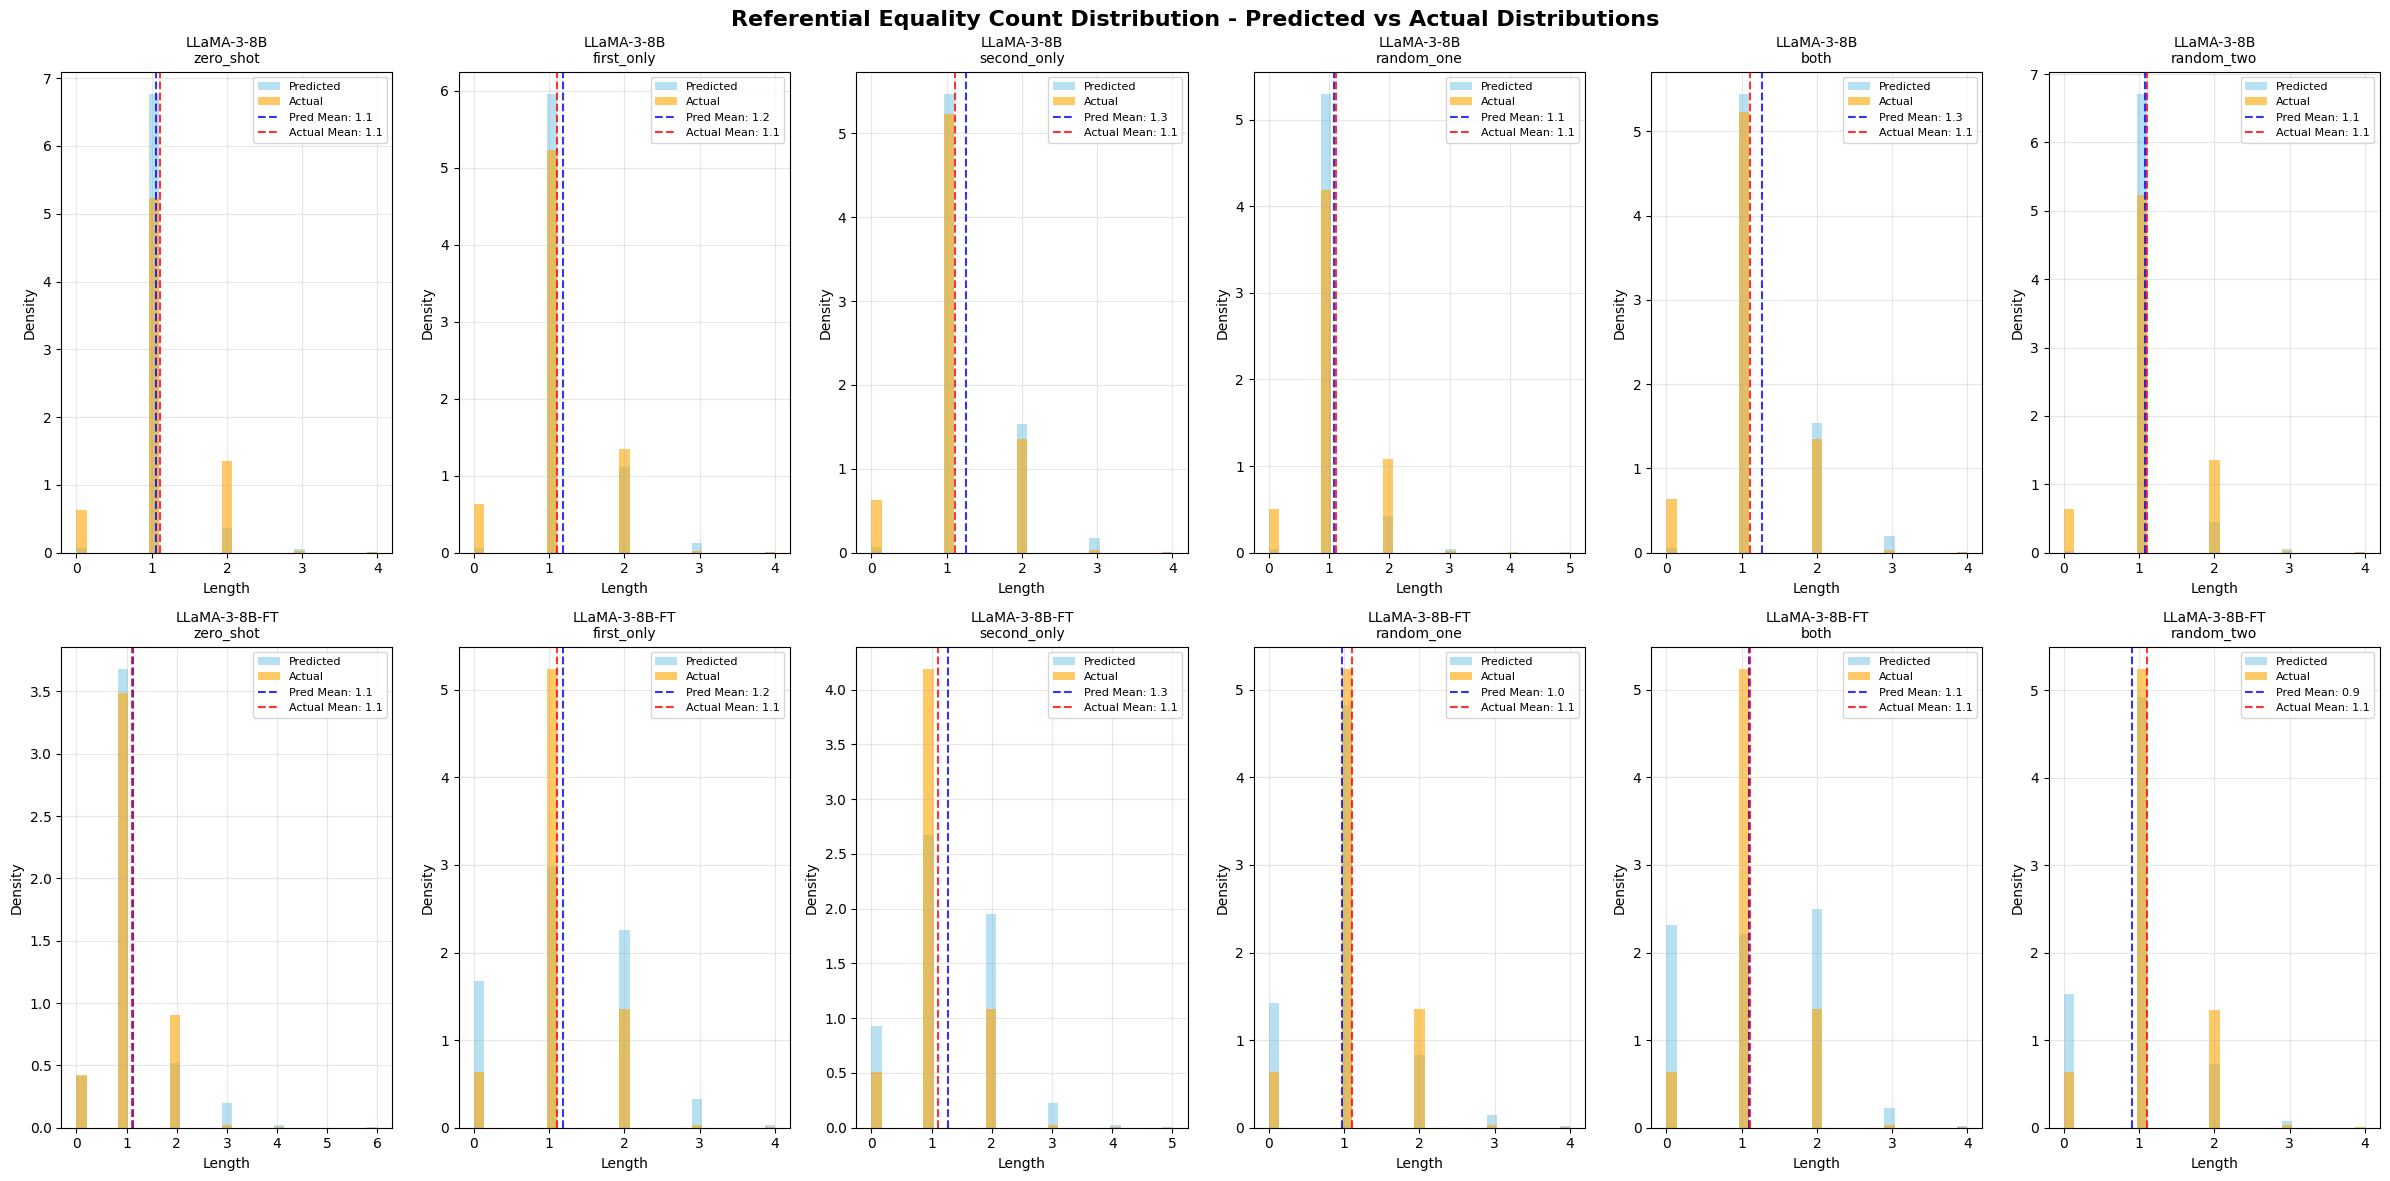

In [17]:

print(f"Referential equality count distributions for Qwen models:")
plot_length_distributions('ref_eq_count', 'Referential Equality Count Distribution', 'Density', quen_models)
print(f"Referential equality count distributions for Llama models:")
plot_length_distributions('ref_eq_count', 'Referential Equality Count Distribution', 'Density', llama_models)

In [18]:
### 5.3 Average Length Trends Across Prompt Types

def plot_average_length_trends():
    """Plot average length trends across prompt types for each model"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Average Length Trends Across Prompt Types', fontsize=16, fontweight='bold')
    
    # Define the components to analyze
    components = [
        ('answer_lengths', 'Answer Lengths', 'Characters'),
        ('question_ref_lengths', 'Question Reference Lengths', 'Characters'),
        ('sentence_ref_lengths', 'Sentence Reference Lengths', 'Characters'),
        ('ref_eq_count', 'Referential Equalities Count', 'Count')
    ]
    
    for idx, (component, title, ylabel) in enumerate(components):
        ax = axes[idx // 2, idx % 2]
        
        # Calculate actual averages once (ground truth is model-independent)
        actual_averages = []
        first_model = list(models.values())[0]  # Use any model to get actual values
        
        for prompt_type in prompt_types:
            stats = prediction_stats[first_model][prompt_type]
            actual_values = stats[f'{component}_actual']
            actual_avg = np.mean(actual_values) if actual_values else 0
            actual_averages.append(actual_avg)
        
        # Plot ground truth line once
        ax.plot(prompt_types, actual_averages, marker='s', linewidth=3, markersize=8, 
            label='GT (Actual)', linestyle='--', alpha=0.9)
        
        # Calculate and plot predicted averages for each model
        for model_name in models.values():
            pred_averages = []
            
            for prompt_type in prompt_types:
                stats = prediction_stats[model_name][prompt_type]
                pred_values = stats[f'{component}_pred']
                pred_avg = np.mean(pred_values) if pred_values else 0
                pred_averages.append(pred_avg)
            
            # Plot predicted trend lines only
            ax.plot(prompt_types, pred_averages, marker='o', linewidth=2, markersize=6, 
                label=f'{model_name}', linestyle='-', alpha=0.8)
        
        ax.set_title(title)
        ax.set_ylabel('Average Length')
        ax.set_xlabel('Prompt Type')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        # Add zero line for reference if relevant
        if component == 'ref_eq_count':
            ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

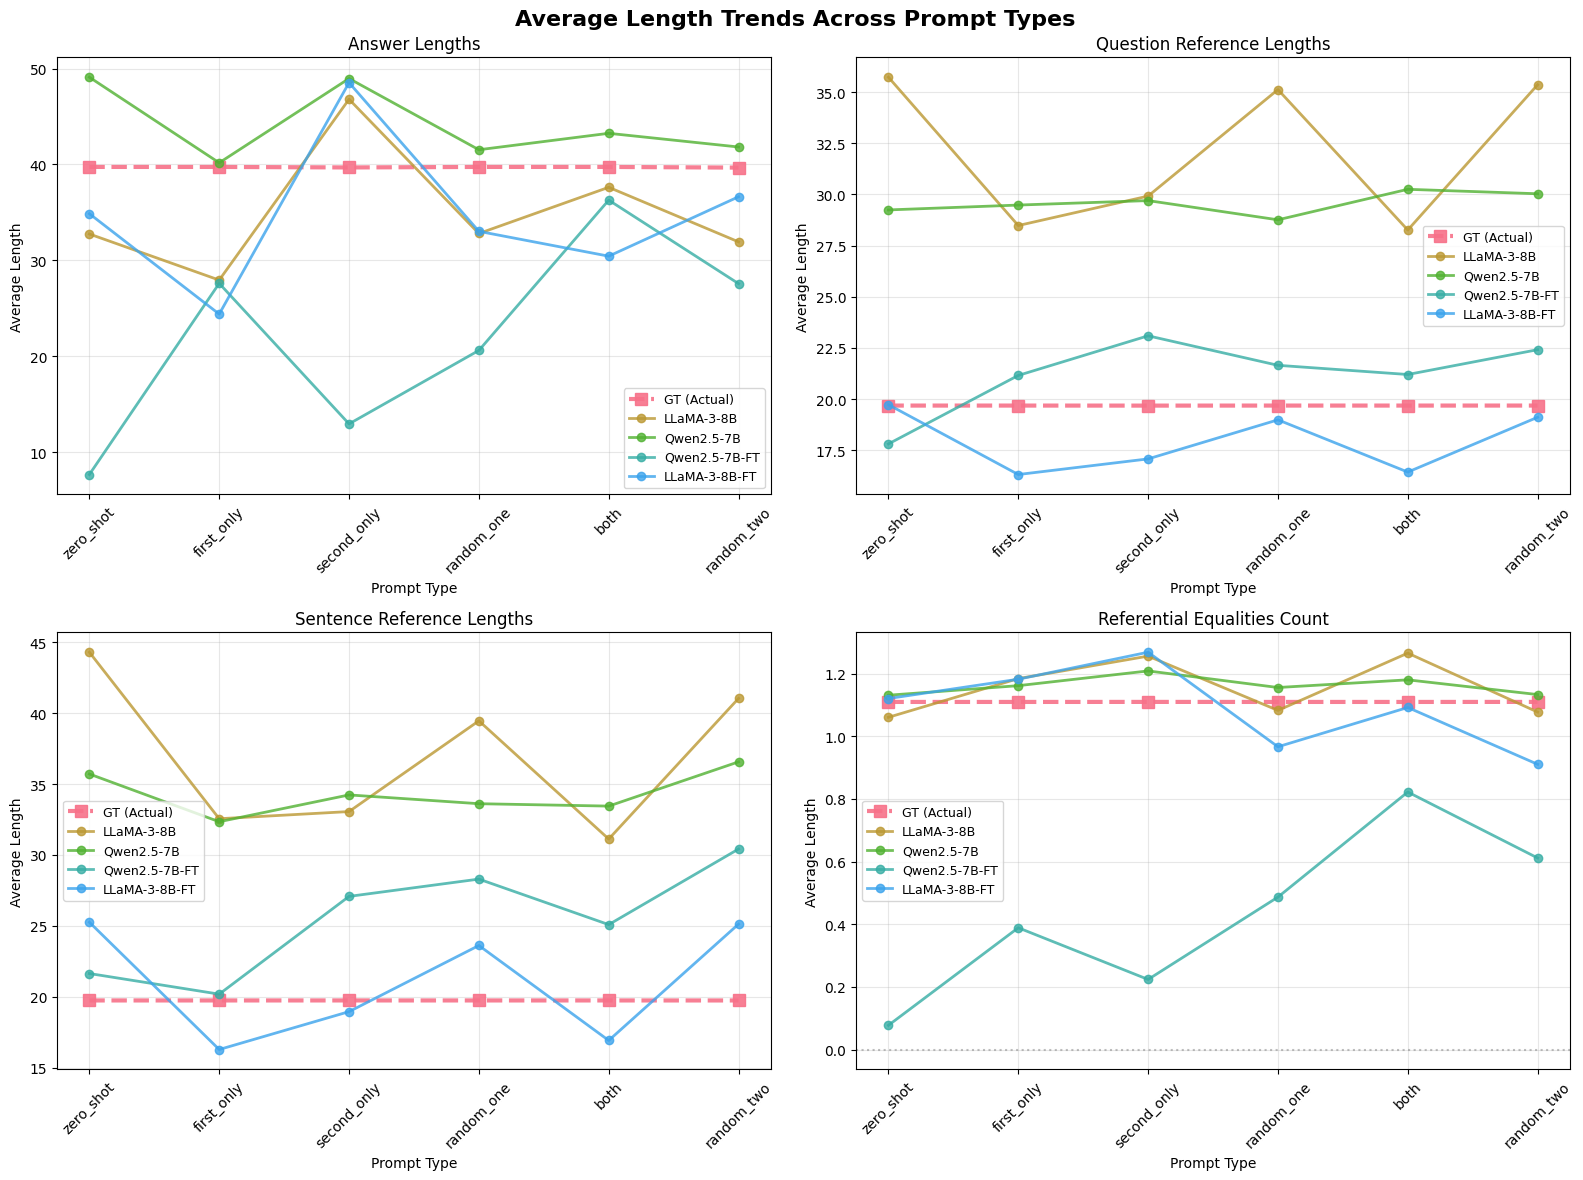

In [19]:
# Create the trend plots
plot_average_length_trends()

In [20]:
### 5.4 Referential Equalities Count Distribution Analysis

def plot_count_distributions(models_names):
    """Plot referential equalities count distributions"""
    fig, axes = plt.subplots(len(models_names), len(prompt_types), figsize=(24, 12))
    fig.suptitle('Referential Equalities Count - Predicted vs Actual Distributions', fontsize=16, fontweight='bold')
    
    for i, model_name in enumerate(models_names):
        for j, prompt_type in enumerate(prompt_types):
            ax = axes[i, j] if len(models_names) > 1 else axes[j]
            
            stats = prediction_stats[model_name][prompt_type]
            pred_counts = stats['ref_eq_count_pred']
            actual_counts = stats['ref_eq_count_actual']
            
            if pred_counts and actual_counts:
                # Create bar plots for counts
                max_count = max(max(pred_counts, default=0), max(actual_counts, default=0))
                bins = range(0, max_count + 2)
                
                pred_hist, _ = np.histogram(pred_counts, bins=bins)
                actual_hist, _ = np.histogram(actual_counts, bins=bins)
                
                x = np.arange(len(bins)-1)
                width = 0.35
                
                ax.bar(x - width/2, pred_hist, width, label='Predicted', color='skyblue', alpha=0.7)
                ax.bar(x + width/2, actual_hist, width, label='Actual', color='orange', alpha=0.7)
                
                # Add statistics
                pred_mean = np.mean(pred_counts) if pred_counts else 0
                actual_mean = np.mean(actual_counts) if actual_counts else 0
                ax.axvline(pred_mean, color='blue', linestyle='--', alpha=0.8, label=f'Pred Mean: {pred_mean:.1f}')
                ax.axvline(actual_mean, color='red', linestyle='--', alpha=0.8, label=f'Actual Mean: {actual_mean:.1f}')
                
                ax.set_xticks(x)
                ax.set_xticklabels([str(i) for i in bins[:-1]])
            
            ax.set_title(f'{model_name}\n{prompt_type}', fontsize=10)
            ax.set_xlabel('Count')
            ax.set_ylabel('Frequency')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



Referential equality count distributions for Qwen models:


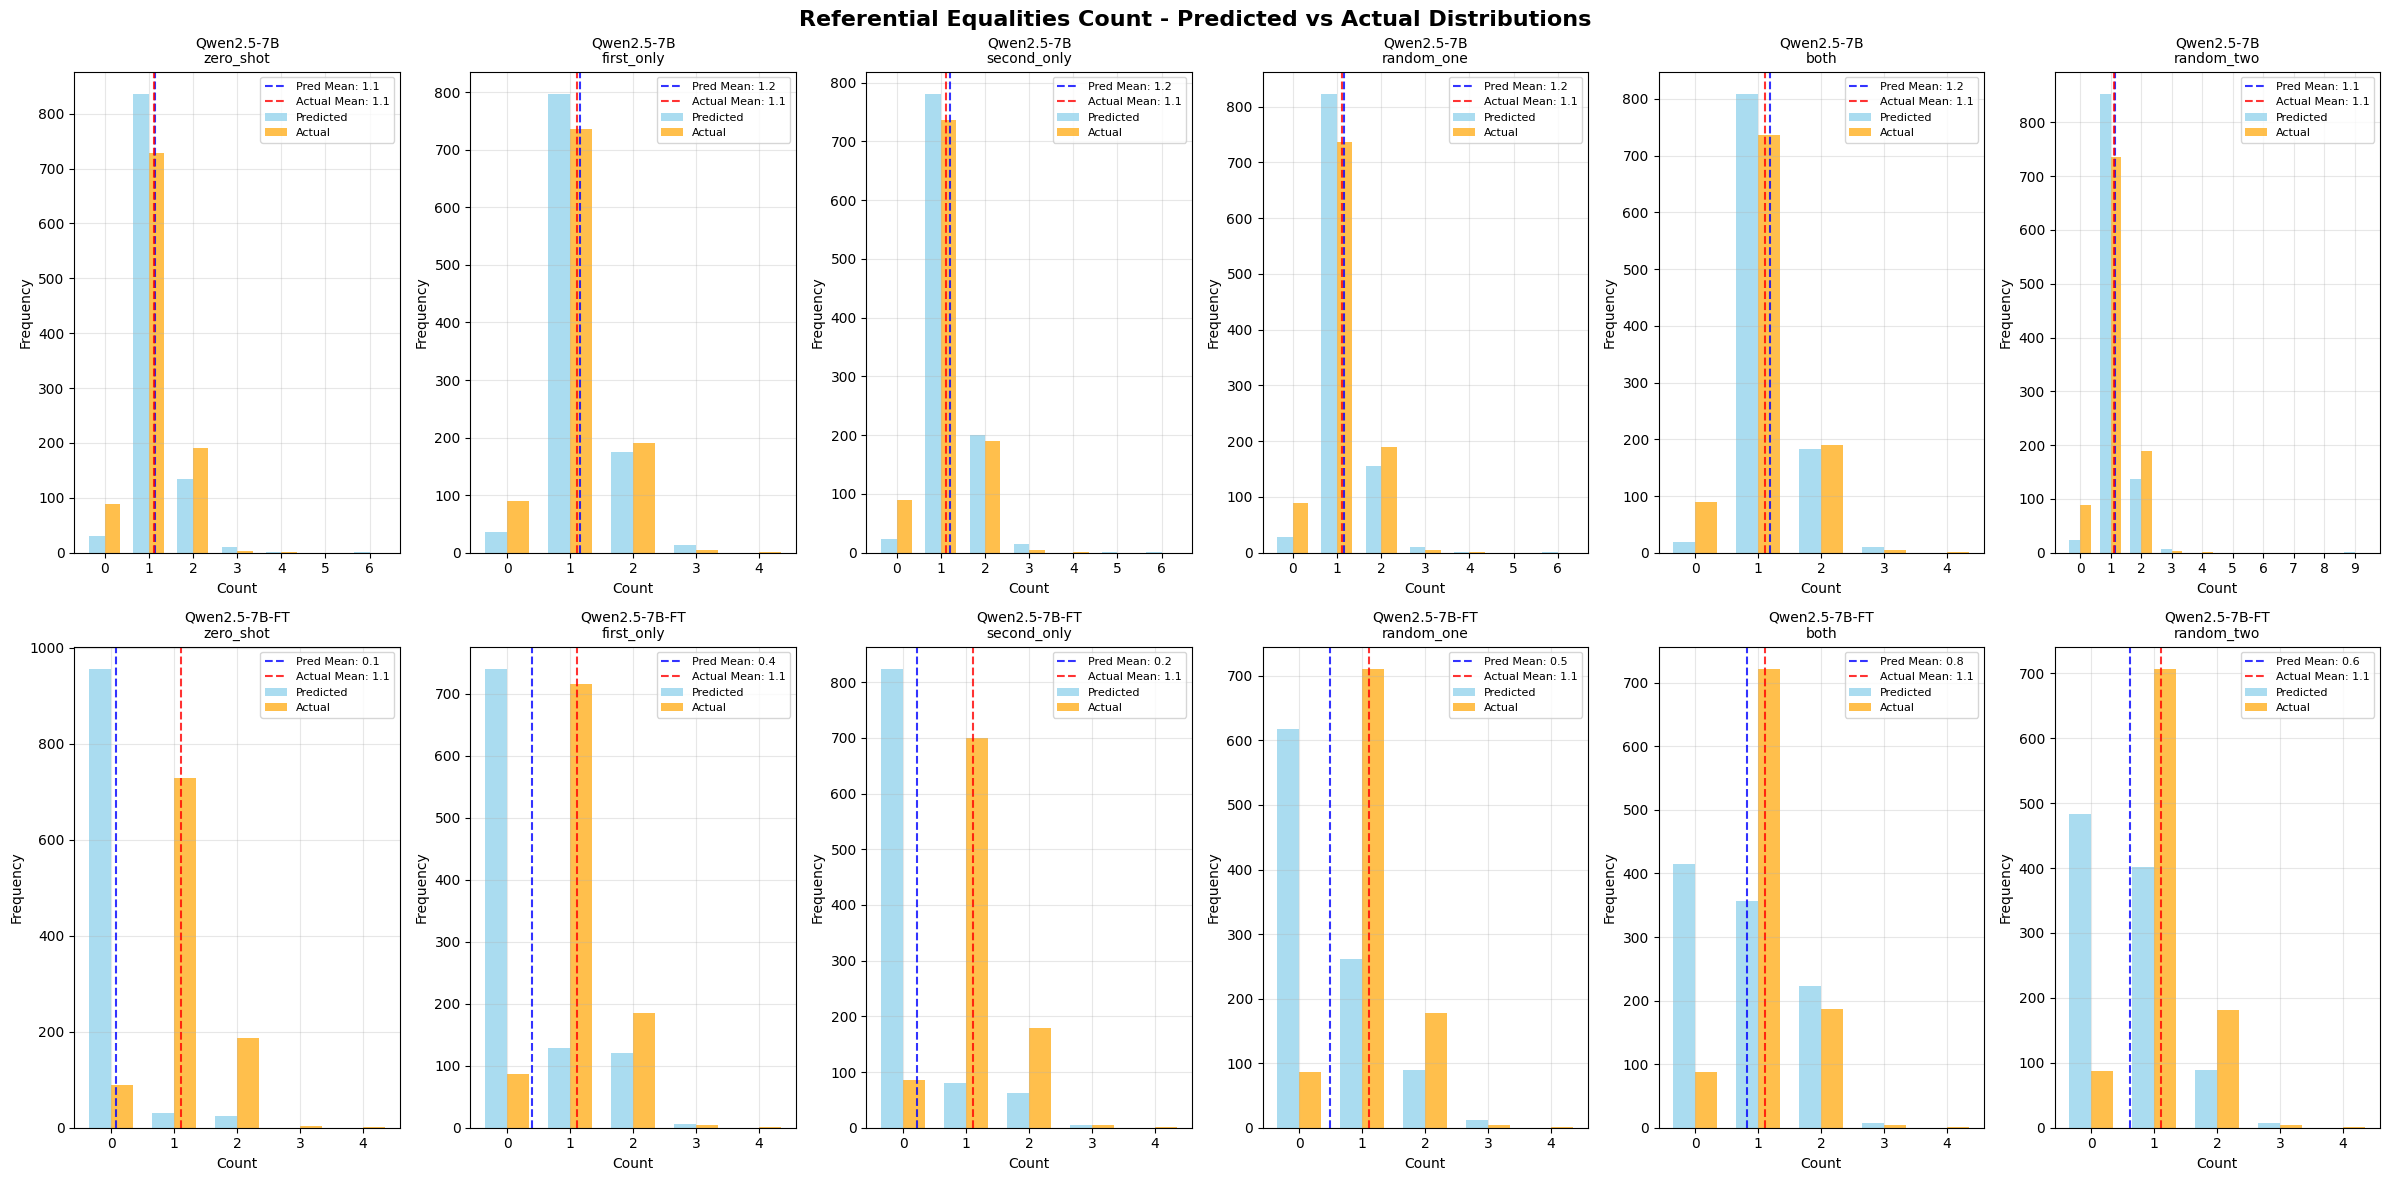

Referential equality count distributions for Llama models:


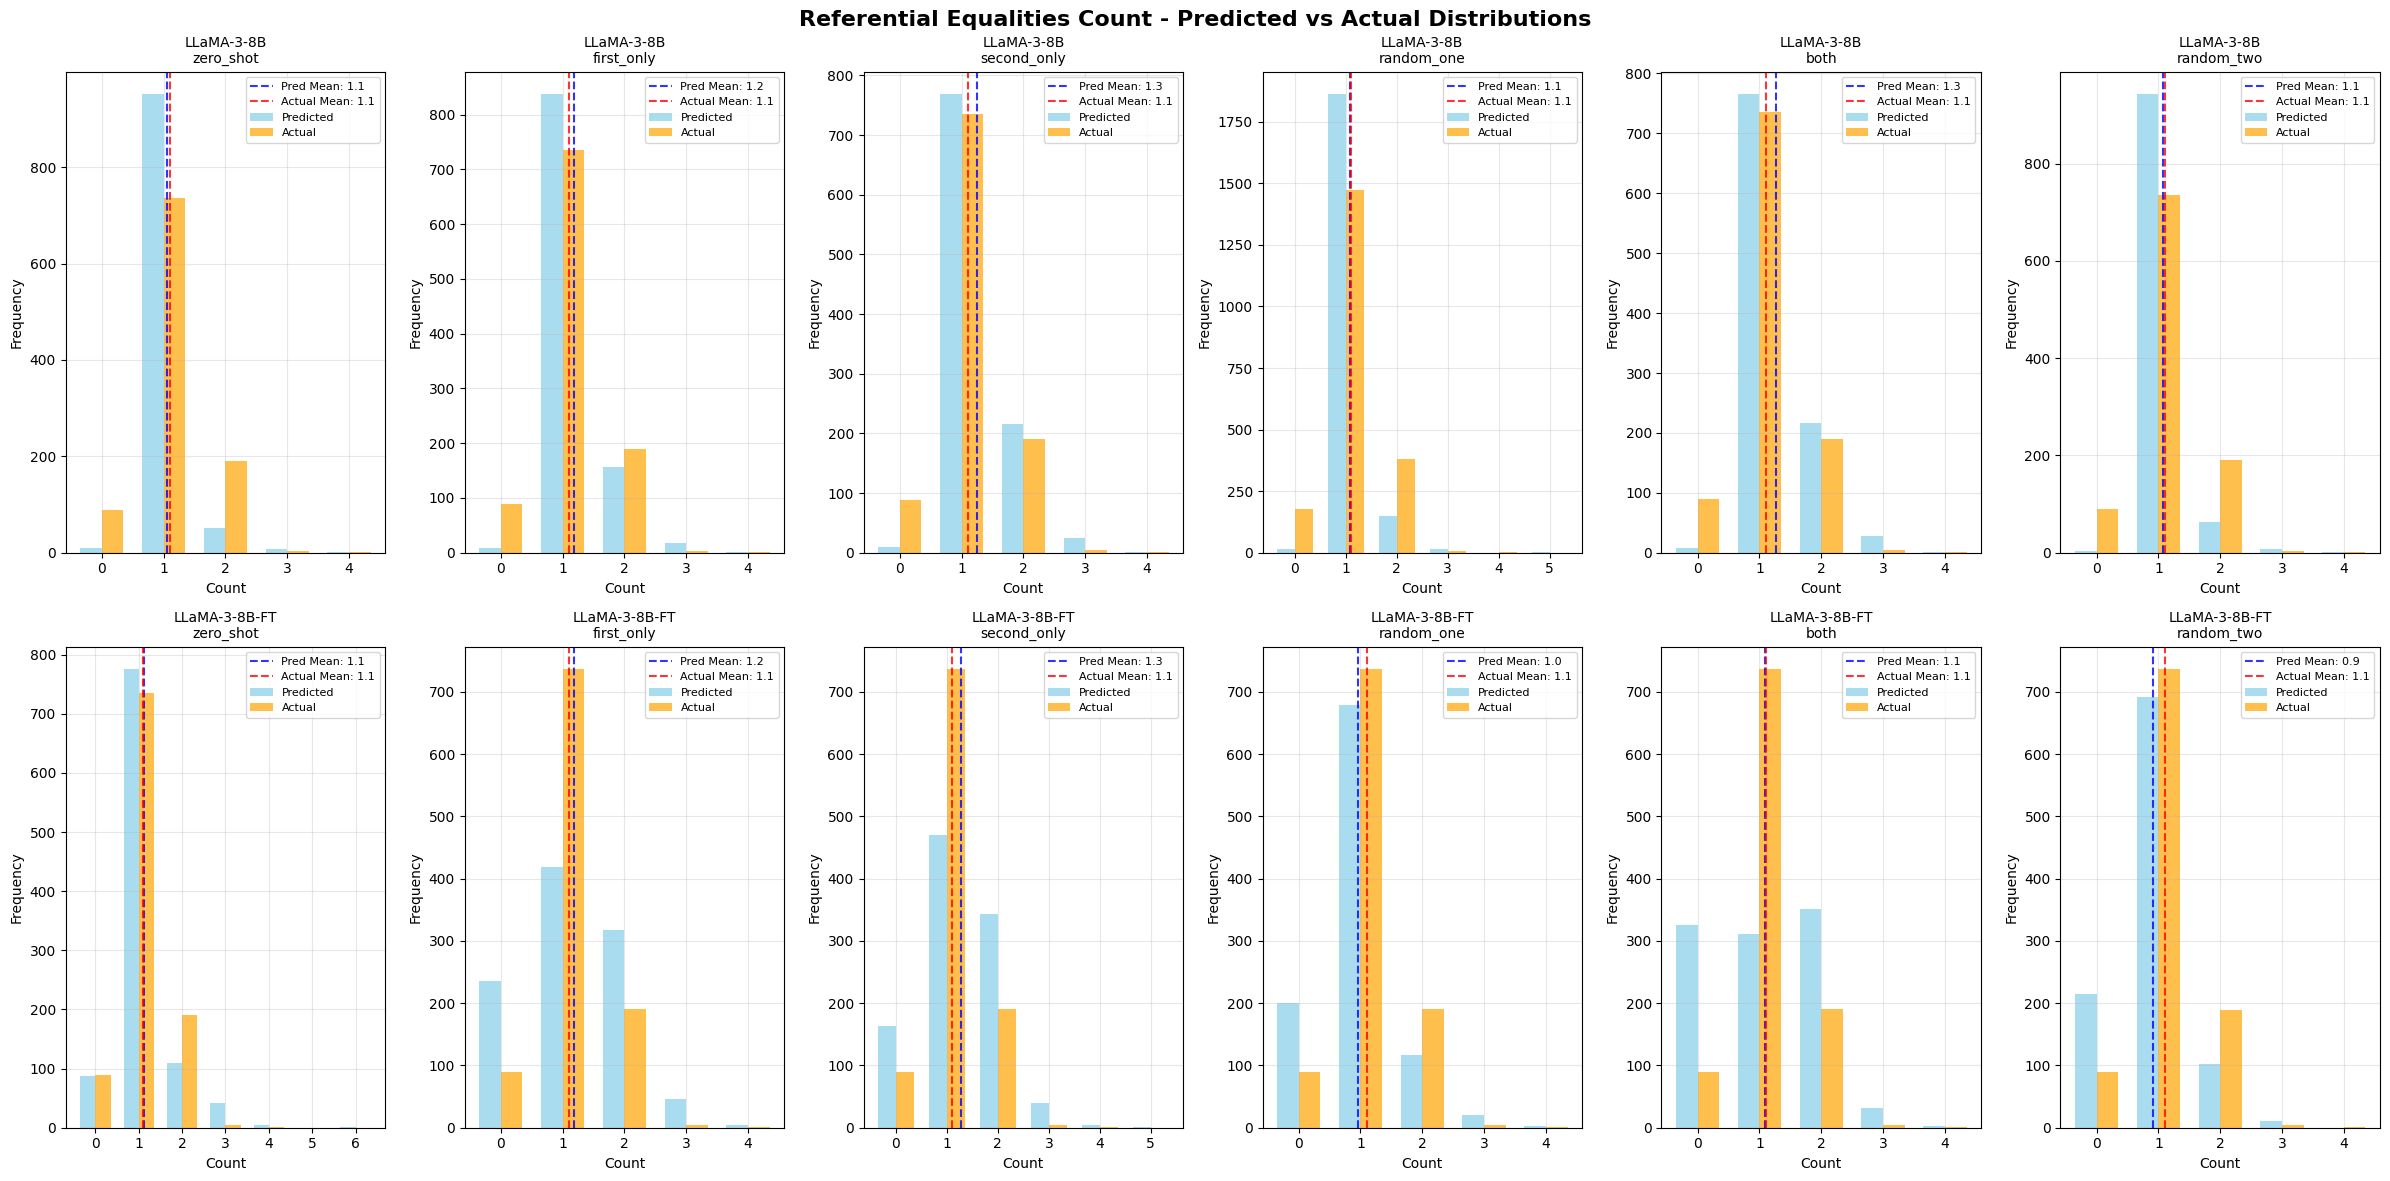

In [21]:
    # Plot referential equalities count distributions
print(f"Referential equality count distributions for Qwen models:")
plot_count_distributions(quen_models)
print(f"Referential equality count distributions for Llama models:")
plot_count_distributions(llama_models)

=== PREDICTION QUALITY SUMMARY STATISTICS ===

📊 ANSWER LENGTHS:
------------------------------------------------------------
        model prompt_type  pred_mean  actual_mean  mean_diff  mean_diff_pct
   LLaMA-3-8B   zero_shot      32.76        39.74      -6.99         -17.58
   LLaMA-3-8B  first_only      27.95        39.74     -11.79         -29.66
   LLaMA-3-8B second_only      46.80        39.69       7.11          17.90
   LLaMA-3-8B  random_one      32.81        39.74      -6.94         -17.45
   LLaMA-3-8B        both      37.62        39.74      -2.12          -5.34
   LLaMA-3-8B  random_two      31.94        39.67      -7.74         -19.50
   Qwen2.5-7B   zero_shot      49.09        39.82       9.27          23.29
   Qwen2.5-7B  first_only      40.18        39.74       0.43           1.09
   Qwen2.5-7B second_only      48.96        39.74       9.21          23.18
   Qwen2.5-7B  random_one      41.53        39.74       1.79           4.51
   Qwen2.5-7B        both      43.25  

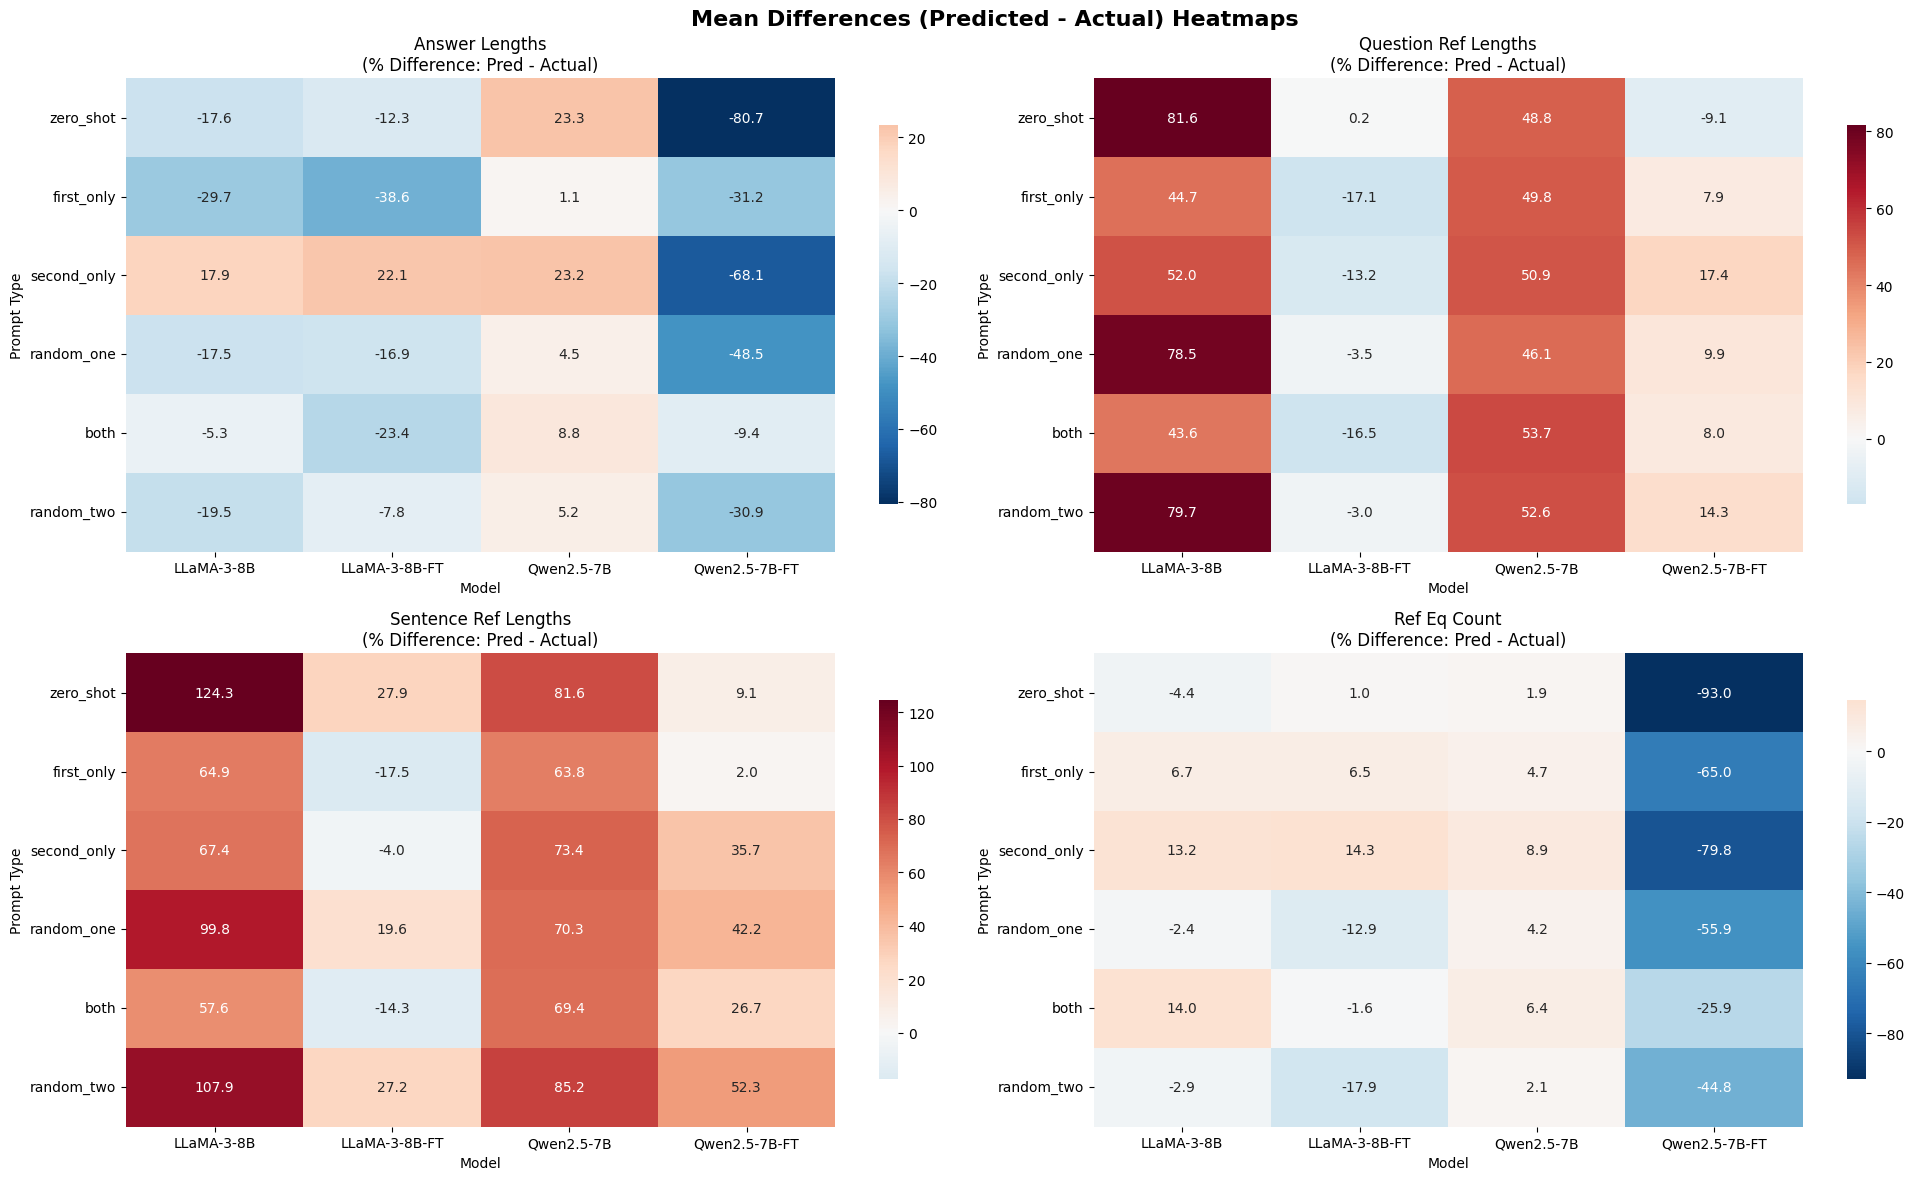

In [22]:
### 5.5 Summary Statistics and Analysis

def calculate_summary_stats():
    """Calculate summary statistics for all components"""
    summary_data = []
    
    for model_name in models.values():
        for prompt_type in prompt_types:
            stats = prediction_stats[model_name][prompt_type]
            
            # Calculate statistics for each component
            components = ['answer_lengths', 'question_ref_lengths', 'sentence_ref_lengths', 'ref_eq_count']
            
            for component in components:
                pred_values = stats[f'{component}_pred']
                actual_values = stats[f'{component}_actual']
                
                if pred_values and actual_values:
                    pred_mean = np.mean(pred_values)
                    actual_mean = np.mean(actual_values)
                    pred_std = np.std(pred_values)
                    actual_std = np.std(actual_values)
                    
                    # Calculate difference metrics
                    mean_diff = pred_mean - actual_mean
                    mean_diff_pct = (mean_diff / actual_mean * 100) if actual_mean != 0 else 0
                    
                    summary_data.append({
                        'model': model_name,
                        'prompt_type': prompt_type,
                        'component': component,
                        'pred_mean': pred_mean,
                        'actual_mean': actual_mean,
                        'pred_std': pred_std,
                        'actual_std': actual_std,
                        'mean_diff': mean_diff,
                        'mean_diff_pct': mean_diff_pct,
                        'pred_count': len(pred_values),
                        'actual_count': len(actual_values)
                    })
    
    return pd.DataFrame(summary_data)

# Calculate and display summary statistics
summary_df = calculate_summary_stats()

print("=== PREDICTION QUALITY SUMMARY STATISTICS ===\n")

# Display by component
for component in ['answer_lengths', 'question_ref_lengths', 'sentence_ref_lengths', 'ref_eq_count']:
    print(f"📊 {component.upper().replace('_', ' ')}:")
    print("-" * 60)
    
    component_data = summary_df[summary_df['component'] == component]
    
    if not component_data.empty:
        display_cols = ['model', 'prompt_type', 'pred_mean', 'actual_mean', 'mean_diff', 'mean_diff_pct']
        print(component_data[display_cols].round(2).to_string(index=False))
    
    print("\n" + "="*60 + "\n")

# Create heatmap showing mean differences across models and prompt types
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Mean Differences (Predicted - Actual) Heatmaps', fontsize=16, fontweight='bold')

components = ['answer_lengths', 'question_ref_lengths', 'sentence_ref_lengths', 'ref_eq_count']
component_titles = ['Answer Lengths', 'Question Ref Lengths', 'Sentence Ref Lengths', 'Ref Eq Count']

for i, (component, title) in enumerate(zip(components, component_titles)):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Create pivot table for heatmap
    component_data = summary_df[summary_df['component'] == component]
    if not component_data.empty:
        pivot_data = component_data.pivot_table(values='mean_diff_pct', index='prompt_type', columns='model', aggfunc='first')
        pivot_data = pivot_data.reindex(prompt_types)
        
        # Create heatmap
        sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='RdBu_r', center=0, ax=ax, 
                   cbar_kws={'shrink': 0.8})
        ax.set_title(f'{title}\n(% Difference: Pred - Actual)')
        ax.set_xlabel('Model')
        ax.set_ylabel('Prompt Type')

plt.tight_layout()
plt.show()